In [1]:
import asyncio
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
import backtrader as bt
import pandas as pd
import numpy as np
import random
import pytz
import time
import os
from xbbg import blp
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
import sympy as sp
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython import get_ipython
import matplotlib.dates as mdates
from pydataquery import DataQuery
import re
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import csv
import uuid
from concurrent.futures import ThreadPoolExecutor
import warnings
from multiprocess import Pool
import time
warnings.filterwarnings('ignore')

In [2]:
# ############## Get list of index bonds from BBG, their dates and finally their YAS_MOD_DUR
# df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
# # df.columns = [item.split('.')[0] for item in df.columns]
# for item in ['5Y','7Y','10Y','30Y']:
#     for i in range(len(df[[f'{item}.1']])):
#     # display(df[[f'{item}.1']])#.equals(df[[f'{item}.2']]))
#     # display(df[[f'{item}.2']])
#         if df[[f'{item}.1']].iloc[i,0] != df[[f'{item}.2']].iloc[i,0] :
#             display(f'item is {item} and i is {i}')
#             display(df[[f'{item}.1']].iloc[i,0], df[[f'{item}.2']].iloc[i,0])

# df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
# for item in ['5Y','7Y','10Y','30Y']:
#     x = df[[item+'.1', item+'.2']].dropna().copy()
#     display(max(x[item+'.2'] - x[item+'.1']))

# df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
# df = df[[col for col in df.columns if not '.2' in col]].copy()
# # df.columns = [item.split('.')[0] for item in df.columns]
# all_dict = {}
# for item in ['5Y','7Y','10Y','30Y']:
#     new_dict = dict(zip(list(df[item+'.3']),list(df[item])))
#     all_dict = {**all_dict, **new_dict}
# df = df[[col for col in df.columns if '.' in col]].copy()

# all_x = None
# for item in ['5Y','7Y','10Y','30Y']:
#     x = df[[item+'.1', item+'.3']].dropna().copy()
#     x.columns = ['Start','Bond']
#     x['Series'] = [item]*len(x)
#     all_x = pd.concat([all_x, x]).reset_index(drop=True).copy()

# all_x['End'] = all_x['Start'] + timedelta(days=30*15)
# new_x = None
# for i in range(len(all_x)):
#     x = pd.DataFrame({'Date':pd.date_range(all_x['Start'].iloc[i],all_x['End'].iloc[i],freq='B')})
#     x['Bond'] = [all_x['Bond'].iloc[i]]*len(x)
#     x['Series'] = [all_x['Series'].iloc[i]]*len(x)
#     new_x = pd.concat([new_x, x]).reset_index(drop=True)
#     # if i<3:
#     #     display(x)
#     #     display(new_x)
#     # # break
#     # =BDP(A1 & " CUSIP", "YAS_MOD_DUR", "SETTLE_DT", TEXT(B1, "YYYYMMDD"))
# new_x['CUSIP'] = new_x['Bond'].apply(lambda x: all_dict[x].split(' ')[0])
# # new_x.to_excel("Duration D1ata.xlsx")

# # df = pd.read_excel("Duration Data.xlsx", parse_dates=True).iloc[:,:-1]
# df1 = df[df['Date']<pd.to_datetime('2025-10-1')].copy()
# df1['Cpn'] = df1['Bond'].apply(lambda x: (x.split(' ',1)[1].rsplit(' ',1)[0]))
# df1['Cpn'] = [eval(item) if not ' ' in item else eval(item.split(' ')[0]) + eval(item.split(' ')[1]) for item in df1['Cpn']]
# df1 = df1.dropna()
# a = pd.pivot_table(index='Date', columns = 'CUSIP', values='Duration',data=df1)
# a.columns = [item+'_Dur' for item in a.columns]
# a.columns.name = None

# b = pd.pivot_table(index='Date', columns = 'CUSIP', values='Cpn',data=df1)
# b.columns = [item+'_Cpn' for item in b.columns]
# b.columns.name = None
# c = pd.concat([a,b],axis=1).sort_index().copy()

# px = blp.bdh(tickers=[item.split('_')[0] + '@BGN Corp' for item in a.columns], flds='PX_LAST', start_date='2010-1-1')
# px.columns = [item[0].replace('@BGN Corp','_PX') for item in px.columns]
# px.index = pd.to_datetime(px.index)
# d = pd.concat([c,px],axis=1)
# d.to_parquet('CT Individual PX, Dur, & Cpn Data.parquet')

In [3]:
############################# this code block is only for PEMEX i.e no dur data in DQ
dq = pd.read_parquet("PA - DQ Data.parquet")
# dq = pd.read_parquet("MEX - DQ Data.parquet")

dq = dq.drop([col for col in dq.columns if 'Rich/Cheap' in col], axis=1)
pecs_cols = [col for col in dq.columns if col.endswith("PECS Bid")]
for item in pecs_cols:
    if item.replace("PECS Bid","PECS Ask") in dq.columns:
        dq[item.replace(" Bid","")] = 0.5*(dq[item] + dq[item.replace("PECS Bid","PECS Ask")])
dq = dq[[col for col in dq.columns if not(col.endswith("PECS Bid")) and not col.endswith("PECS Ask")]].copy()

dq = dq[[col for col in dq.columns if not col.startswith("CT")]].copy()
dq.columns = dq.columns.str.replace(dq.columns[2], f"{dq.columns[2].split(" ")[0]}" + " CDS PX")
dq[dq.columns[2]] = 100 - dq[dq.columns[2]]

cds = dq.iloc[:,:3].copy()
cds.columns = ["CDS 5Y Dur","CDS 5Y Par Sprd","CDS 5Y PX"]
original_cds = cds.copy()
x = cds[['CDS 5Y Dur']].copy()
x.columns = ['PA Dur']

####################################################
# dq = pd.read_parquet("PA - DQ Data.parquet")
dq = pd.read_parquet("MEX - DQ Data.parquet")

dq = dq.drop([col for col in dq.columns if 'Rich/Cheap' in col], axis=1)
pecs_cols = [col for col in dq.columns if col.endswith("PECS Bid")]
for item in pecs_cols:
    if item.replace("PECS Bid","PECS Ask") in dq.columns:
        dq[item.replace(" Bid","")] = 0.5*(dq[item] + dq[item.replace("PECS Bid","PECS Ask")])
dq = dq[[col for col in dq.columns if not(col.endswith("PECS Bid")) and not col.endswith("PECS Ask")]].copy()

dq = dq[[col for col in dq.columns if not col.startswith("CT")]].copy()
dq.columns = dq.columns.str.replace(dq.columns[2], f"{dq.columns[2].split(" ")[0]}" + " CDS PX")
dq[dq.columns[2]] = 100 - dq[dq.columns[2]]

cds = dq.iloc[:,:3].copy()
cds.columns = ["CDS 5Y Dur","CDS 5Y Par Sprd","CDS 5Y PX"]
original_cds = cds.copy()
x['MEX Dur'] = cds[['CDS 5Y Dur']]

x1 = x.copy()
x1['PA Dur'] = x1['PA Dur'].fillna(x1['MEX Dur'])
x1['MEX Dur'] = x1['MEX Dur'].fillna(x1['PA Dur'])
x1['PEMEX Dur'] = x1.mean(axis=1)
x1 = x1[['PEMEX Dur']].copy()

In [4]:

isin_list = ["US105756BX78", "US105756BZ27", "US105756CA66", "US105756CC23", "US105756CG37", "US105756CE88", "US105756CK49", "US105756CF53", "US105756CH10", "US105756BW95", "US105756BY51", "US105756CB40", "US105756CJ75", "US168863DX33", "US168863CF36", "US168863EB04", "US168863DP09", "US168863DN50", "US168863DT21", "US168863DV76", "US168863DZ80", "US168863DS48", "US168863DY16", "US168863CE60", "US168863DL94", "US168863DW59", "XS2327851874", "US168863EA21", "US168863DQ81", "US168863DU93", "US195325CX13", "US195325DL65", "US195325DP79", "US195325DR36", "US195325DS19", "US195325DZ51", "US195325EF88", "US195325EG61", "US195325EL56", "US195325BK01", "US195325BM66", "US195325EA91", "US195325BR53", "US195325CU73", "US195325DQ52", "US195325DT91", "US195325EM30", "US195325DX04", "US91086QBG29", "US91087BAC46", "US91087BAE02", "US91087BAU44", "US91087BAF76", "US91087BAY65", "US91087BAH33", "US91087BAM28", "US91087BAK61", "US91087BAT70", "US91087BAR15", "US91087BAV27", "US91087BAZ31", "US91086QAV05", "US91087BAQ32", "US91086QBB32", "US91086QBE70", "US91086QBF46", "US91087BAB62", "US91087BAD29", "US91087BAG59", "US91087BAL45", "US91087BAS97", "US91087BAX82", "US91087BBA70", "US91087BAN01", "XS2280637039", "US91086QAZ19", "USP90603AN40", "US698299BF03", "US698299BK97", "US698299BX19", "USP90603AP97", "US698299BN37", "US698299BR41", "US698299BT07", "US698299AW45", "US698299BW36", "US698299BY91", "US698299BG85", "US698299BH68", "US698299BB98", "US698299BV52", "US698299BM53", "US698299BL70", "US698299BS24", "US715638DE95", "US715638BU55", "US715638DA73", "US715638DF60", "US715638DP43", "US715638DU38", "US715638EB48", "US715638DS81", "US715638BM30", "US715638DT64", "US715638EC21", "US715638DQ26", "US715638DW93", "US715638DR09", "US836205AT15", "US836205AW44", "US836205AU87", "US836205BA15", "US836205AY00", "US836205BC70", "US836205AS32", "US836205AV60", "US836205AX27", "US836205BB97", "US836205BE37", "US900123DB31", "US900123CJ75", "US900123CK49", "US900123CL22", "USM88269US88", "US900123DF45", "US900123CP36", "US900123CQ19", "US900123DH01", "US900123CT57", "US900123CY43", "US900123DJ66", "US900123DA57", "US900123DC14", "US900123DL13", "US900123DG28", "US900123DD96", "US900123AT75", "US900123DK30", "US900123DN78", "US900123AY60", "US900123BB58", "US900123BG46", "US900123BJ84", "US900123CB40", "US900123CG37", "US900123CM05", "USP3579EBK21", "USP3579EBV85", "USP3579ECB13", "USP3579ECP09", "USP3579ECF27", "USP3579ECR64", "USP3579ECH82", "USP3579ECN50", "USP3579ECU93", "USP3579ECJ49", "USP3579EAY34", "USP3579EBE60", "USP3579EBY25", "USP3579ECE51", "USP3579ECG00", "US71654QDH20", "US71654QBW15", "US71654QCB68", "US71654QDB59", "US71654QCG55", "US71654QCK67", "US71654QCP54", "US71654QDL32", "US71654QDC33", "US71654QDE98", "US71643VAB18", "US71654QDP46", "US706451BG56", "US71654QAZ54", "US71654QBR20", "US71654QCC42", "US71654QCL41", "US71654QDD16", "US71654QDF63", "US71656MAF68", "US71647NAS80", "US71647NAY58", "US71647NBH17", "US71647NBK46", "US71647NBL29", "US71645WAQ42", "US71645WAS08", "US71647NAK54", "US71647NBJ72", "US71647NAN93",
             "XS2214237807", "XS2214239506", "XS2214238441", "XS2214239175", "US040114HX11", "US040114HS26", "US040114HT09", "US040114HU71", "US040114HV54", "US040114HW38", "XS1910826996", "XS1717011982", "XS2384698994", "XS2445169985", "XS1777972511", "XS1910827887", "XS2948511949", "XS1566179039", "XS2384701020", "XS2948512913", "XS1777972941", "XS1717013095", "XS1910828182", "XS2384704800", "XS1843435840", "XS1781710543", "XS2764839945", "XS1843435766", "XS2354781614", "XS1781710626", "XS1318576086", "XS1819680288", "XS2083302419", "XS2446175577", "XS1819680528", "XS2083302500", "XS1790104530", "XS1619155564", "XS2333676133", "XS1790134362", "XS2297220423", "XS1903488572", "XS1558078736", "XS2391394348", "XS1775618439", "XS1504948776", "XS1953057061", "XS1903489463", "XS2297226545", "XS2079842642", "XS2176897754", "XS2391395154", "XS1558078496", "XS1775617464", "XS1953057491", "XS2176899701", "XS2391398174", "USP01012BX31", "USP01012CF16", "XS0146173371", "USP01012AN67", "USP01012AR71", "USP01012CA29", "USP01012CC84", "USP01012CH71", 
             "USP7808BAA54", "USP7808BAB38", "XS0505478684", "XS2079846635", "XS2297221405", 
             "USG2583XAB76", "USL21779AL44", "USL21779AJ97", "USL21779AK60", 
             "XS2322319398", "XS1729875598", "XS2419405274", "XS2322319638", "XS2322321964",
             "USN15516AB83", "USN15516AD40", "USN15516AH53","USN15516AG70","USN15516AJ10","USU1065PAA94",
             "USN15516AE23"
            ]
isin_list += ['XS2965710598','US105756CL22','US105756CM05','US168863EE43','US195325ER27','US195325EQ44','US195325EP60','US195325ES00','US25714PFB94','US25714PFC77','XS2990500766','XS2989586941','XS3010561762','US91087BBB53','US91087BBF67','US91087BBE92','US91087BBC37','US91087BBD10','US715638FD94','US715638FC12','US836205BF02','XS2917537875','US900123DQ00']
isin_list += ["US60367QAC78", "US16955EAC49", "US455780CB07", "US455780BM70", "US455780BY19", "US455780BJ42", "US455780BU96", "US455780BW52", "US455780BR67", "US455780AX45", "US455780AZ92", "US455780AT33", "US455780CV60", "US455780CY00", "US455780CQ75", "US455780CR58", "US455780CW44", "US455780DG84", "US455780CX27", "US455780DJ24", "US455780CN45", "US455780CS32", "US455780DX18", "US455780CT15", "US455780DK96", "US455780CE46", "US455780CU87", "US455780DN36", "US455780DU78", "US455780DR40", "US455780DZ65", "US455780DV51", "US455780DW35", "US455780CJ33", "US455780EA06", "US455780DS23"]
isin_list += ["XS2290957146", "US05675M2G83", "XS2408003064", "US05675M2J23", "XS2058948451", "US05675M2A14", "XS2226916216", "US05675M2D52", "XS1675862012", "US05674RAJ32", "XS2764424813", "US05675M2L78", "XS2611617700", "US05675M2K95", "XS2172965282", "US05675M2C79", "US50064FAS39", "XS2294322818", "US80413TAV17", "XS2109766472", "US80413TAQ22", "XS2159975700", "US80413TAT60", "XS1791939066", "US80413TAH23", "XS2747598444", "US80413TBF57", "XS2577135127", "US80413TBD00", "XS2747599095", "US80413TBG31", "XS2548892020", "US80413TBA60", "XS2974968161", "US80413TBK43", "XS2974969482", "US80413TBL26", "XS2288905370", "US68205LAS25", "XS2234859283", "US68205LAE39", "US718286CK14", "US718286CN52", "US718286CJ41", "US718286CR66", "US718286DC88", "US718286BW60", "US718286CW51", "US718286DG92", "US718286DA23", "US718286CT23", "US718286BD89", "US718286BG11", "US718286BB24", "US718286AY36", "XS2155352664", "US74727PBD24", "XS2822506833", "US74738PTP35", "XS2918565198", "US74738PUJ55", "XS0113419690", "US74727PAE16"]

names_list = ["BRAZIL 6 04/07/26", "BRAZIL 4 5/8 01/13/28", "BRAZIL 4 1/2 05/30/29", "BRAZIL 3 7/8 06/12/30", "BRAZIL 6 1/4 03/18/31", "BRAZIL 3 3/4 09/12/31", "BRAZIL 6 1/8 01/22/32", "BRAZIL 6 10/20/33", "BRAZIL 6 1/8 03/15/34", "BRAZIL 5 01/27/45", "BRAZIL 5 5/8 02/21/47", "BRAZIL 4 3/4 01/14/50", "BRAZIL 7 1/8 05/13/54", "CHILE 2 3/4 01/31/27", "CHILE 3.24 02/06/28", "CHILE 4.85 01/22/29", "CHILE 2.45 01/31/31", "CHILE 2.55 01/27/32", "CHILE 2.55 07/27/33", "CHILE 3 1/2 01/31/34", "CHILE 4.95 01/05/36", "CHILE 3.1 05/07/41", "CHILE 4.34 03/07/42", "CHILE 3.86 06/21/47", "CHILE 3 1/2 01/25/50", "CHILE 4 01/31/52", "CHILE 3 1/2 04/15/53", "CHILE 5.33 01/05/54", "CHILE 3.1 01/22/61", "CHILE 3 1/4 09/21/2071", "COLOM 4 1/2 01/28/26", "COLOM 3 7/8 04/25/27", "COLOM 4 1/2 03/15/29", "COLOM 3 01/30/30", "COLOM 3 1/8 04/15/31", "COLOM 3 1/4 04/22/32", "COLOM 8 04/20/33", "COLOM 7 1/2 02/02/34", "COLOM 8 11/14/35", "COLOM 7 3/8 09/18/37", "COLOM 6 1/8 01/18/41", "COLOM 4 1/8 02/22/42", "COLOM 5 5/8 02/26/44", "COLOM 5 06/15/45", "COLOM 5.2 05/15/49", "COLOM 4 1/8 05/15/51", "COLOM 8 3/4 11/14/53", "COLOM 3 7/8 02/15/61", "MEX 4 1/8 01/21/26", "MEX 4.15 03/28/27", "MEX 3 3/4 01/11/28", "MEX 5.4 02/09/28", "MEX 4 1/2 04/22/29", "MEX 5 05/07/29", "MEX 3 1/4 04/16/30", "MEX 2.659 05/24/31", "MEX 4 3/4 04/27/32", "MEX 4 7/8 05/19/33", "MEX 3 1/2 02/12/34", "MEX 6.35 02/09/35", "MEX 6 05/07/36", "MEX 6.05 01/11/40", "MEX 4.28 08/14/41", "MEX 4 3/4 03/08/44", "MEX 5.55 01/21/45", "MEX 4.6 01/23/46", "MEX 4.35 01/15/47", "MEX 4.6 02/10/48", "MEX 4 1/2 01/31/50", "MEX 5 04/27/51", "MEX 4.4 02/12/52", "MEX 6.338 05/04/53", "MEX 6.4 05/07/54", "MEX 3.771 05/24/61", "MEX 3 3/4 04/19/2071", "MEX 5 3/4 10/12/2110", "PANAMA 3 3/4 04/17/26", "PANAMA 3 7/8 03/17/28", "PANAMA 3.16 01/23/30", "PANAMA 7 1/2 03/01/31", "PANAMA 3.362 06/30/31", "PANAMA 2.252 09/29/32", "PANAMA 3.298 01/19/33", "PANAMA 6.4 02/14/35", "PANAMA 6.7 01/26/36", "PANAMA 6 7/8 01/31/36", "PANAMA 8 03/01/38", "PANAMA 4 1/2 05/15/47", "PANAMA 4 1/2 04/16/50", "PANAMA 4.3 04/29/53", "PANAMA 6.853 03/28/54", "PANAMA 4 1/2 04/01/56", "PANAMA 3.87 07/23/60", "PANAMA 4 1/2 01/19/63", "PERU 2.392 01/23/26", "PERU 4 1/8 08/25/27", "PERU 2.844 06/20/30", "PERU 2.783 01/23/31", "PERU 1.862 12/01/32", "PERU 3 01/15/34", "PERU 5 3/8 02/08/35", "PERU 3.3 03/11/41", "PERU 5 5/8 11/18/50", "PERU 3.55 03/10/51", "PERU 5 7/8 08/08/54", "PERU 2.78 12/01/60", "PERU 3.6 01/15/2072", "PERU 3.23 07/28/2121", "SOAF 4 7/8 04/14/26", "SOAF 4.85 09/27/27", "SOAF 4.3 10/12/28", "SOAF 4.85 09/30/29", "SOAF 5 7/8 06/22/30", "SOAF 5 7/8 04/20/32", "SOAF 5 3/8 07/24/44", "SOAF 5 10/12/46", "SOAF 5.65 09/27/47", "SOAF 5 3/4 09/30/49", "SOAF 7.3 04/20/52", "TURKEY 4 3/4 01/26/26", "TURKEY 4 1/4 04/14/26", "TURKEY 4 7/8 10/09/26", "TURKEY 6 03/25/27", "TURKEY 8.6 09/24/27", "TURKEY 9 7/8 01/15/28", "TURKEY 5 1/8 02/17/28", "TURKEY 6 1/8 10/24/28", "TURKEY 9 3/8 03/14/29", "TURKEY 7 5/8 04/26/29", "TURKEY 5 1/4 03/13/30", "TURKEY 9 1/8 07/13/30", "TURKEY 5.95 01/15/31", "TURKEY 5 7/8 06/26/31", "TURKEY 7 1/8 07/17/32", "TURKEY 9 3/8 01/19/33", "TURKEY 6 1/2 09/20/33", "TURKEY 8 02/14/34", "TURKEY 7 5/8 05/15/34", "TURKEY 6 1/2 01/03/35", "TURKEY 6 7/8 03/17/36", "TURKEY 7 1/4 03/05/38", "TURKEY 6 3/4 05/30/40", "TURKEY 6 01/14/41", "TURKEY 4 7/8 04/16/43", "TURKEY 6 5/8 02/17/45", "TURKEY 5 3/4 05/11/47", "DOMREP 6 7/8 01/29/26", "DOMREP 5.95 01/25/27", "DOMREP 6 07/19/28", "DOMREP 5 1/2 02/22/29", "DOMREP 4 1/2 01/30/30", "DOMREP 7.05 02/03/31", "DOMREP 4 7/8 09/23/32", "DOMREP 6 02/22/33", "DOMREP 6.6 06/01/36", "DOMREP 5.3 01/21/41", "DOMREP 7.45 04/30/44", "DOMREP 6.85 01/27/45", "DOMREP 6 1/2 02/15/48", "DOMREP 6.4 06/05/49", "DOMREP 5 7/8 01/30/60", "PEMEX 6 7/8 10/16/25", "PEMEX 4 1/2 01/23/26", "PEMEX 6 7/8 08/04/26", "PEMEX 6.49 01/23/27", "PEMEX 6 1/2 03/13/27", "PEMEX 5.35 02/12/28", "PEMEX 6 1/2 01/23/29", "PEMEX 8 3/4 06/02/29", "PEMEX 6.84 01/23/30", "PEMEX 5.95 01/28/31", "PEMEX 6.7 02/16/32", "PEMEX 10 02/07/33", "PEMEX 6 5/8 06/15/35", "PEMEX 6 1/2 06/02/41", "PEMEX 6 3/8 01/23/45", "PEMEX 6 3/4 09/21/47", "PEMEX 6.35 02/12/48", "PEMEX 7.69 01/23/50", "PEMEX 6.95 01/28/60", "PEMEX 6 5/8 PERP", "PETBRA 7 3/8 01/17/27", "PETBRA 5.999 01/27/28", "PETBRA 5.6 01/03/31", "PETBRA 6 1/2 07/03/33", "PETBRA 6 01/13/35", "PETBRA 6 7/8 01/20/40", "PETBRA 6 3/4 01/27/41", "PETBRA 7 1/4 03/17/44", "PETBRA 5 1/2 06/10/51", "PETBRA 6.85 06/05/2115",
             "ECUA 6.9 07/31/30", "ECUA 0 07/31/30", "ECUA 6.9 07/31/35", "ECUA 5 07/31/40", "ARGENT 1 07/09/29", "ARGENT 0 3/4 07/09/30", "ARGENT 4 1/8 07/09/35", "ARGENT 5 01/09/38", "ARGENT 3 1/2 07/09/41", "ARGENT 4 1/8 07/09/46", "NGERIA 7 5/8 11/21/25", "NGERIA 6 1/2 11/28/27", "NGERIA 6 1/8 09/28/28", "NGERIA 8 3/8 03/24/29", "NGERIA 7.143 02/23/30", "NGERIA 8.747 01/21/31", "NGERIA 9 5/8 06/09/31", "NGERIA 7 7/8 02/16/32", "NGERIA 7 3/8 09/28/33", "NGERIA 10 3/8 12/09/34", "NGERIA 7.696 02/23/38", "NGERIA 7 5/8 11/28/47", "NGERIA 9.248 01/21/49", "NGERIA 8 1/4 09/28/51", "KENINT 7 05/22/27", "KENINT 7 1/4 02/28/28", "KENINT 9 3/4 02/16/31", "KENINT 8 05/22/32", "KENINT 6.3 01/23/34", "KENINT 8 1/4 02/28/48", "ANGOL 9 1/2 11/12/25", "ANGOL 8 1/4 05/09/28", "ANGOL 8 11/26/29", "ANGOL 8 3/4 04/14/32", "ANGOL 9 3/8 05/08/48", "ANGOL 9 1/8 11/26/49", "SENEGL 4 3/4 03/13/28", "SENEGL 6 1/4 05/23/33", "SENEGL 5 3/8 06/08/37", "SENEGL 6 3/4 03/13/48", "EGYPT 3 7/8 02/16/26", "EGYPT 7 1/8 11/10/26", "EGYPT 7 1/2 01/31/27", "EGYPT 5.8 09/30/27", "EGYPT 6.588 02/21/28", "EGYPT 7 11/10/28", "EGYPT 7.6003 03/01/29", "EGYPT 7 5/8 11/10/30", "EGYPT 5 7/8 02/16/31", "EGYPT 7.0529 01/15/32", "EGYPT 7 5/8 05/29/32", "EGYPT 7.3 09/30/33", "EGYPT 8 1/2 01/31/47", "EGYPT 7.903 02/21/48", "EGYPT 8.7002 03/01/49", "EGYPT 8 7/8 05/29/50", "EGYPT 8 3/4 09/30/51", "ELSALV 8 5/8 02/28/29", "ELSALV 9 1/4 04/17/30", "ELSALV 8 1/4 04/10/32", "ELSALV 7.65 06/15/35", "ELSALV 7 5/8 02/01/41", "ELSALV 7.1246 01/20/50", "ELSALV 9 1/2 07/15/52", "ELSALV 9.65 11/21/54", 
             "PETRPE 4 3/4 06/19/32", "PETRPE 5 5/8 06/19/47", "EGYPT 6 7/8 04/30/40", "EGYPT 8.15 11/20/59", "EGYPT 7 1/2 02/16/61", 
             "CSNABZ 6 3/4 01/28/28", "CSNABZ 8 7/8 12/05/30", "CSNABZ 4 5/8 06/10/31", "CSNABZ 5 7/8 04/08/32",
             "PKSTAN 6 04/08/26", "PKSTAN 6 7/8 12/05/27", "PKSTAN 7.95 01/31/29", "PKSTAN 7 3/8 04/08/31", "PKSTAN 8 7/8 04/08/51",
             "BRASKM 4.5 01/10/28", "BRASKM 4.5 01/31/30","BRASKM 8.5 01/12/31","BRASKM 7.25 02/13/33","BRASKM 8 10/15/34","BRASKM 7.125 07/22/41", "BRASKM 5.875 01/31/50",
             ]
names_list += ['ANGOL 10.95 12/27/30', 'BRAZIL 6 5/8 03/15/35', 'BRAZIL 5 1/2 11/06/30', 'CHILE 5.65 01/13/37', 'COLOM 7 3/8 04/25/30', 'COLOM 8 3/8 11/07/54', 'COLOM 7 3/4 11/07/36', 'COLOM 8 1/2 04/25/35', 'DOMREP 6.95 03/15/37', 'DOMREP 7.15 02/24/55', 'EGYPT 9.45 02/04/33', 'EGYPT 8 5/8 02/04/30', 'KENINT 9 1/2 03/05/36', 'MEX 6 05/13/30', 'MEX 6 5/8 01/29/38', 'MEX 5.85 07/02/32', 'MEX 6 7/8 05/13/37', 'MEX 7 3/8 05/13/55', 'PERU 6.2 06/30/55', 'PERU 5 1/2 03/30/36', 'SOAF 7.1 11/19/36', 'SOAF 7.95 11/19/54', 'TURKEY 7 1/4 05/29/32']
names_list += ["CHINA 1 3/4 10/26/31", "CHINA 1.2 10/21/30", "INDON 4 3/4 07/18/47", "INDON 4 5/8 04/15/43", "INDON 5 1/4 01/08/47", "INDON 5 1/4 01/17/42", "INDON 5 1/8 01/15/45", "INDON 5.95 01/08/46", "INDON 6 3/4 01/15/44", "INDON 6 5/8 02/17/37", "INDON 7 3/4 01/17/38", "INDON 8 1/2 10/12/35", "INDON 1.85 03/12/31", "INDON 2.15 07/28/31", "INDON 2.85 02/14/30", "INDON 3 1/2 02/14/50", "INDON 3.05 03/12/51", "INDON 3.2 09/23/61", "INDON 3.35 03/12/2071", "INDON 3.55 03/31/32", "INDON 3.7 10/30/49", "INDON 3.85 10/15/30", "INDON 4 3/4 09/10/34", "INDON 4.2 10/15/50", "INDON 4.3 03/31/52", "INDON 4.35 01/11/48", "INDON 4.45 04/15/70", "INDON 4.65 09/20/32", "INDON 4.7 02/10/34", "INDON 4.85 01/11/33", "INDON 5 1/4 01/15/30", "INDON 5.1 02/10/54", "INDON 5.15 09/10/54", "INDON 5.35 02/11/49", "INDON 5.6 01/15/35", "INDON 5.65 01/11/53"]
names_list += ["BHRAIN 5 1/4 01/25/33", "BHRAIN 5 1/4 01/25/33", "BHRAIN 5 5/8 05/18/34", "BHRAIN 5 5/8 05/18/34", "BHRAIN 5 5/8 09/30/31", "BHRAIN 5 5/8 09/30/31", "BHRAIN 5.45 09/16/32", "BHRAIN 5.45 09/16/32", "BHRAIN 6 3/4 09/20/29", "BHRAIN 6 3/4 09/20/29", "BHRAIN 7 1/2 02/12/36", "BHRAIN 7 1/2 02/12/36", "BHRAIN 7 3/4 04/18/35", "BHRAIN 7 3/4 04/18/35", "BHRAIN 7 3/8 05/14/30", "BHRAIN 7 3/8 05/14/30", "KOREA 1 09/16/30", "KSA 2 1/4 02/02/33", "KSA 2 1/4 02/02/33", "KSA 2 3/4 02/03/32", "KSA 2 3/4 02/03/32", "KSA 3 1/4 10/22/30", "KSA 3 1/4 10/22/30", "KSA 4 1/2 04/17/30", "KSA 4 1/2 04/17/30", "KSA 4 3/4 01/16/30", "KSA 4 3/4 01/16/30", "KSA 4 7/8 07/18/33", "KSA 4 7/8 07/18/33", "KSA 5 01/16/34", "KSA 5 01/16/34", "KSA 5 1/2 10/25/32", "KSA 5 1/2 10/25/32", "KSA 5 3/8 01/13/31", "KSA 5 3/8 01/13/31", "KSA 5 5/8 01/13/35", "KSA 5 5/8 01/13/35", "OMAN 6 1/4 01/25/31", "OMAN 6 1/4 01/25/31", "OMAN 7 3/8 10/28/32", "OMAN 7 3/8 10/28/32", "PHILIP 1.648 06/10/31", "PHILIP 1.95 01/06/32", "PHILIP 2.457 05/05/30", "PHILIP 3.556 09/29/32", "PHILIP 4 3/4 03/05/35", "PHILIP 5 01/13/37", "PHILIP 5 07/17/33", "PHILIP 5 1/2 02/04/35", "PHILIP 5 1/4 05/14/34", "PHILIP 5.609 04/13/33", "PHILIP 6 3/8 01/15/32", "PHILIP 6 3/8 10/23/34", "PHILIP 7 3/4 01/14/31", "PHILIP 9 1/2 02/02/30", "QATAR 3 3/4 04/16/30", "QATAR 3 3/4 04/16/30", "QATAR 4 3/4 05/29/34", "QATAR 4 3/4 05/29/34", "QATAR 4 7/8 02/27/35", "QATAR 4 7/8 02/27/35", "QATAR 9 3/4 06/15/30", "QATAR 9 3/4 06/15/30"]

new_dict = dict(zip(names_list, isin_list))
all_dict = {'ECUA 6.9 07/31/30': 'XS2214237807', 'ECUA 0 07/31/30': 'XS2214239506', 'ECUA 6.9 07/31/35': 'XS2214238441', 'ECUA 5 07/31/40': 'XS2214239175', 'ARGENT 1 07/09/29': 'US040114HX11', 'ARGENT 0 3/4 07/09/30': 'US040114HS26', 'ARGENT 4 1/8 07/09/35': 'US040114HT09', 'ARGENT 5 01/09/38': 'US040114HU71', 'ARGENT 3 1/2 07/09/41': 'US040114HV54', 'ARGENT 4 1/8 07/09/46': 'US040114HW38', 'NGERIA 7 5/8 11/21/25': 'XS1910826996', 'NGERIA 6 1/2 11/28/27': 'XS1717011982', 'NGERIA 6 1/8 09/28/28': 'XS2384698994', 'NGERIA 8 3/8 03/24/29': 'XS2445169985', 'NGERIA 7.143 02/23/30': 'XS1777972511', 'NGERIA 8.747 01/21/31': 'XS1910827887', 'NGERIA 9 5/8 06/09/31': 'XS2948511949', 'NGERIA 7 7/8 02/16/32': 'XS1566179039', 'NGERIA 7 3/8 09/28/33': 'XS2384701020', 'NGERIA 10 3/8 12/09/34': 'XS2948512913', 'NGERIA 7.696 02/23/38': 'XS1777972941', 'NGERIA 7 5/8 11/28/47': 'XS1717013095', 'NGERIA 9.248 01/21/49': 'XS1910828182', 'NGERIA 8 1/4 09/28/51': 'XS2384704800', 'KENINT 7 05/22/27': 'XS1843435840', 'KENINT 7 1/4 02/28/28': 'XS1781710543', 'KENINT 9 3/4 02/16/31': 'XS2764839945', 'KENINT 8 05/22/32': 'XS1843435766', 'KENINT 6.3 01/23/34': 'XS2354781614', 'KENINT 8 1/4 02/28/48': 'XS1781710626', 'ANGOL 9 1/2 11/12/25': 'XS1318576086', 'ANGOL 8 1/4 05/09/28': 'XS1819680288', 'ANGOL 8 11/26/29': 'XS2083302419', 'ANGOL 8 3/4 04/14/32': 'XS2446175577', 'ANGOL 9 3/8 05/08/48': 'XS1819680528', 'ANGOL 9 1/8 11/26/49': 'XS2083302500', 'SENEGL 4 3/4 03/13/28': 'XS1790104530', 'SENEGL 6 1/4 05/23/33': 'XS1619155564', 'SENEGL 5 3/8 06/08/37': 'XS2333676133', 'SENEGL 6 3/4 03/13/48': 'XS1790134362', 'ELSALV 8 5/8 02/28/29': 'USP01012BX31', 'ELSALV 9 1/4 04/17/30': 'USP01012CF16', 'ELSALV 8 1/4 04/10/32': 'XS0146173371', 'ELSALV 7.65 06/15/35': 'USP01012AN67', 'ELSALV 7 5/8 02/01/41': 'USP01012AR71', 'ELSALV 7.1246 01/20/50': 'USP01012CA29', 'ELSALV 9 1/2 07/15/52': 'USP01012CC84', 'ELSALV 9.65 11/21/54': 'USP01012CH71', 'EGYPT 3 7/8 02/16/26': 'XS2297220423', 'EGYPT 7 1/8 11/10/26': 'XS1903488572', 'EGYPT 7 1/2 01/31/27': 'XS1558078736', 'EGYPT 5.8 09/30/27': 'XS2391394348', 'EGYPT 6.588 02/21/28': 'XS1775618439', 'EGYPT 7 11/10/28': 'XS1504948776', 'EGYPT 7.6003 03/01/29': 'XS1953057061', 'EGYPT 7 5/8 11/10/30': 'XS1903489463', 'EGYPT 5 7/8 02/16/31': 'XS2297226545', 'EGYPT 7.0529 01/15/32': 'XS2079842642', 'EGYPT 7 5/8 05/29/32': 'XS2176897754', 'EGYPT 7.3 09/30/33': 'XS2391395154', 'EGYPT 6 7/8 04/30/40': 'XS0505478684', 'EGYPT 8 1/2 01/31/47': 'XS1558078496', 'EGYPT 7.903 02/21/48': 'XS1775617464', 'EGYPT 8.7002 03/01/49': 'XS1953057491', 'EGYPT 8 7/8 05/29/50': 'XS2176899701', 'EGYPT 8 3/4 09/30/51': 'XS2391398174', 'EGYPT 8.15 11/20/59': 'XS2079846635', 'EGYPT 7 1/2 02/16/61': 'XS2297221405', 'PEMEX 6 7/8 10/16/25': 'US71654QDH20', 'PEMEX 4 1/2 01/23/26': 'US71654QBW15', 'PEMEX 6 7/8 08/04/26': 'US71654QCB68', 'PEMEX 6.49 01/23/27': 'US71654QDB59', 'PEMEX 6 1/2 03/13/27': 'US71654QCG55', 'PEMEX 5.35 02/12/28': 'US71654QCK67', 'PEMEX 6 1/2 01/23/29': 'US71654QCP54', 'PEMEX 8 3/4 06/02/29': 'US71654QDL32', 'PEMEX 6.84 01/23/30': 'US71654QDC33', 'PEMEX 5.95 01/28/31': 'US71654QDE98', 'PEMEX 6.7 02/16/32': 'US71643VAB18', 'PEMEX 10 02/07/33': 'US71654QDP46', 'PEMEX 6 5/8 06/15/35': 'US706451BG56', 'PEMEX 6 1/2 06/02/41': 'US71654QAZ54', 'PEMEX 6 3/8 01/23/45': 'US71654QBR20', 'PEMEX 6 3/4 09/21/47': 'US71654QCC42', 'PEMEX 6.35 02/12/48': 'US71654QCL41', 'PEMEX 7.69 01/23/50': 'US71654QDD16', 'PEMEX 6.95 01/28/60': 'US71654QDF63', 'PEMEX 6 5/8 PERP': 'US71656MAF68', 'PETRPE 4 3/4 06/19/32': 'USP7808BAA54', 'PETRPE 5 5/8 06/19/47': 'USP7808BAB38', 'CSNABZ 6 3/4 01/28/28': 'USG2583XAB76', 'CSNABZ 8 7/8 12/05/30': 'USL21779AL44', 'CSNABZ 4 5/8 06/10/31': 'USL21779AJ97', 'CSNABZ 5 7/8 04/08/32': 'USL21779AK60', 'PKSTAN 6 04/08/26': 'XS2322319398', 'PKSTAN 6 7/8 12/05/27': 'XS1729875598', 'PKSTAN 7.95 01/31/29': 'XS2419405274', 'PKSTAN 7 3/8 04/08/31': 'XS2322319638', 'PKSTAN 8 7/8 04/08/51': 'XS2322321964',
'ANGOL 10.95 12/27/30': 'XS2214237807','EGYPT 9.45 02/04/33': 'XS2214239506','EGYPT 8 5/8 02/04/30': 'XS2214238441','ELSALV 9.65 11/21/54': 'XS2214239175','KENINT 9 1/2 03/05/36': 'US040114HX11','NGERIA 10 3/8 12/09/34': 'US040114HS26','NGERIA 9 5/8 06/09/31': 'US040114HT09','BRASKM 4.5 01/10/28': 'USN15516AB83','BRASKM 4.5 01/31/30': 'USN15516AD40','BRASKM 8.5 01/12/31': 'USN15516AH53','BRASKM 7.25 02/13/33': 'USN15516AG70','BRASKM 8 10/15/34': 'USN15516AJ10','BRASKM 7.125 07/22/41': 'USU1065PAA94','BRASKM 5.875 01/31/50': 'USN15516AE23',
'PETBRA 7 3/8 01/17/27': 'US71647NAS80', 'PETBRA 5.999 01/27/28': 'US71647NAY58', 'PETBRA 5.6 01/03/31': 'US71647NBH17', 'PETBRA 6 1/2 07/03/33': 'US71647NBK46', 'PETBRA 6 01/13/35': 'US71647NBL29', 'PETBRA 6 7/8 01/20/40': 'US71645WAQ42', 'PETBRA 6 3/4 01/27/41': 'US71645WAS08', 'PETBRA 7 1/4 03/17/44': 'US71647NAK54', 'PETBRA 5 1/2 06/10/51': 'US71647NBJ72', 'PETBRA 6.85 06/05/2115': 'US71647NAN93', }

#Making Manual Adj. for Perp Bond of PEMEX
# names_list[names_list.index("PEMEX 6 5/8 PERP")] = "PEMEX 6 5/8 01/01/2999"

all_dict = {**all_dict, **new_dict}
names_list = list(all_dict.keys())
names_list = ["PEMEX 6 5/8 01/01/2199" if item == "PEMEX 6 5/8 PERP" else item for item in names_list]
isin_list = list(all_dict.values())

all_dict = dict(zip(names_list, isin_list))

##################  Change here only
mat_date = [item.split(" ")[-1] for item in names_list]
names_list = [item.split(' ',1)[0] + ' ' + item.rsplit(' ',1)[0].split(' ',1)[1] + '% due ' + item.rsplit('/',1)[-1] for item in names_list]
mat_dict = dict(zip(names_list, mat_date))

fields = [
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatDurSprdEffWrst)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatCdsPESpreadAsk)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatCdsPESpreadBid)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatMidPrice)"],         
          ["DB(SAGE,INSTRUMENT,id_isin,", ",AM_IDX_TOT)"],
          # ["DB(SAGE,INSTRUMENT,id_isin,", ",StatRtAskStripSolMid)*100"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatCdsBasis)"],
          # ["DB(SAGE,INSTRUMENT,id_isin,", ",StatDurSprdEffWrst)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",CMStatCdsPESpreadAskIsrDistance)"],
         ]
          
field_names = ['Duration', 
               'PECS Ask', 'PECS Bid', 
               'Price','TR','Basis','Rich/Cheap Model Sprd to Curve',]

dq_list = []
full_names = []

for i in range(len(isin_list)):
    for j in range(len(fields)):
        dq_list = dq_list + [fields[j][0] + isin_list[i] + fields[j][1]]
        full_names = full_names + [names_list[i] + ' ' + field_names[j]]

labels = dict(zip(full_names, dq_list))

################################################# PA Data Only
new_labels = {}
for key, val in labels.items():
    if key.split(" ")[0] == "PEMEX": ############################################### PEMEX I.E. COUNTRY SELECTION FOR BOND
        new_labels[key] = val

# ###################################### ONE OFF = ONLY FOR FINDING WHICH BOND to Use
# test_dict = {}
# for key, val in new_labels.items():
#     if "Duration" in key:
#         test_dict[key.rsplit(" ",1)[0]] = val.split(",")[-2]

# test_dict_reverse = dict(zip(test_dict.values(), test_dict.keys()))

# lp = ["/isin/" + item + "@BGN" for item in test_dict.values()]
# x = blp.bdp(tickers=lp, flds='ISSUE_DT')
# x.index = [test_dict_reverse[item.split("/")[-1].split("@")[0]] for item in x.index]
# x.sort_values(by=x.columns[0])
# ###################################### ONE OFF = ONLY FOR FINDING WHICH



################################################################################# CHANGE COUNTRY CDS NAME

cds_dict = {"PEMEX Par 5Y CDS Sprd": "DB(SAGE,CDS,MX Pemex Credit Swap 5Yr,CdsPerSprdMid)",
"PEMEX Dur": "DB(SAGE,CDS,MX Pemex Credit Swap 5Yr,StatCdsRiskyAnnuityValue)",
"PEMEX Uf 100": "DB(SAGE,CDS,MX Pemex Credit Swap 5Yr,CdsPrcMid)",}

d = {"Hot Run | 5 year note | Current | Mid Price" : "DB(FHR,N5,MIDPRC)", "Hot Run | 5 year note | Current | Coupon" : "DB(FHR,N5,COUPON)", "Hot Run | 7 year note | Current | Mid Price" : "DB(FHR,N7,MIDPRC)", "Hot Run | 7 year note | Current | Coupon" : "DB(FHR,N7,COUPON)", "Hot Run | 10 year note | Current | Mid Price" : "DB(FHR,N10,MIDPRC)", "Hot Run | 10 year note | Current | Coupon" : "DB(FHR,N10,COUPON)", "Hot Run | 20 year bond | Current | Mid Price" : "DB(FHR,B20,MIDPRC)", "Hot Run | 20 year bond | Current | Coupon" : "DB(FHR,B20,COUPON)", "Hot Run | 30 year bond | Current | Mid Price" : "DB(FHR,B30,MIDPRC)", "Hot Run | 30 year bond | Current | Coupon" : "DB(FHR,B30,COUPON)", "Hot Run | 5 year note | Current | Modified Duration" : "DB(FHR,N5,MODDUR)", "Hot Run | 7 year note | Current | Modified Duration" : "DB(FHR,N7,MODDUR)", "Hot Run | 10 year note | Current | Modified Duration" : "DB(FHR,N10,MODDUR)", "Hot Run | 20 year bond | Current | Modified Duration" : "DB(FHR,B20,MODDUR)", "Hot Run | 30 year bond | Current | Modified Duration" : "DB(FHR,B30,MODDUR)"
    }
new_d = {}
for key, val in d.items():
    new_d["CT" + key.split(" | ")[1].replace(" year note","").replace(" year bond","") + "_" + key.split(" | ")[-1].\
        replace("Mid Price","PX")] = val

################################################# MEX Data Only
labels = {**new_labels, **cds_dict, **new_d}

labels["Fed Fund"] = "FF"

all_start_date = str((datetime.now()-timedelta(days=365*15)).strftime("%Y-%m-%d"))

# dq = DataQuery(
# client_id='jbAIMF2Tkp0JO3sc',
# client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
# )

# job = dq.create_job(expressions = list(labels.values()))
# dq.start_date = all_start_date
# var = job.execute()
# df = job.to_pivot_table()
# df = df.T
# df.index = pd.to_datetime(df.index, format='%Y%m%d').date
# df.index.name = 'Date'

# df.rename(columns={v:k for k, v in labels.items()},inplace=True)
# df.columns.name = None
# clear_output(wait=False)
# df = df.dropna(how='all')
# df = df.dropna(axis=1, how='all')

# dq = df.copy()
# dq.to_parquet("PEMEX - DQ Data.parquet") ##################################### CHANGE NAME OF CDS

# # ############################################## Dur data for PEMEX was mising so we fill with avg of PA and MEX
# dq1 = dq.copy()
# dq1[['PEMEX Par 5Y CDS Sprd']] = 100*dq1[['PEMEX Par 5Y CDS Sprd']]
# dq1['PEMEX Dur'] = x1['PEMEX Dur']
# dq1 = dq1.dropna(subset=['PEMEX Dur'])
# dq1['PEMEX Uf 100'] = [np.nan] * (len(dq1)-1) + [91]   #91 was px of PEMEX CDS 5Y from bbg CDSW on 10/1/2025

# dq1['PX Change'] = dq1['PEMEX Par 5Y CDS Sprd'].diff()*-1*10**-4*dq1['PEMEX Dur']*100
# dq1['PX Change'] = dq1['PX Change'].fillna(0.0)
# dq1['PX'] = dq1['PX Change'].cumsum()
# dq1['PX'] = dq1['PX'] - dq1['PX'].iloc[-1] + 91
# dq1['PEMEX Uf 100'] = 100 - dq1['PX']
# dq1 = dq1.drop(['PX Change','PX'],axis=1)
# l1 = [col for col in dq1.columns if col.startswith('CT')]
# l2 = ['PEMEX Dur','PEMEX Par 5Y CDS Sprd','PEMEX Uf 100']
# dq1 = dq1[l1+l2+[col for col in dq1.columns if not col in l1 and not col in l2]]
# dq = dq1.copy()

# dq.to_parquet("PEMEX - DQ Data.parquet")

In [5]:
df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
df = df[[col for col in df.columns if not '.2' in col and not '.3' in col]]

all_x = None
for i in range(len(df.columns))[::2]:
    x = df.iloc[:,i:i+2].dropna(how="all").copy()
    x.columns = [x.columns[0],'Start Date']
    x.columns = ['Bond','Start Date']
    x['End Date'] = x['Start Date'].shift(-1)
    all_x = pd.concat([all_x, x])
all_x['Bond'] = all_x['Bond'].apply(lambda x: x.split(' ')[0])
all_x['End Date'] = all_x['End Date'] - timedelta(days=1)

ct_dict = {}
for dt in pd.date_range('2010-1-1','2025-10-25',freq='B'):
    test_date = dt
    all_x['Selection'] = all_x.apply(lambda row: ((row['Start Date'] <= test_date) and (row['End Date'] >= test_date)), axis=1)
    current_cts = all_x[all_x['Selection']]['Bond'].to_list()
    if len(current_cts) == 4:
        ct_dict[str(test_date.date())] = current_cts
        # if len(current_cts) != 4:
        #     display(current_cts, dt)

In [6]:
bbg_rates_data = pd.read_parquet('CT Individual PX, Dur, & Cpn Data.parquet')
bbg_rates_data.index = bbg_rates_data.index.date

cusips = [col.split('_')[0] for col in bbg_rates_data.columns if '_Dur' in col]

# dq = pd.read_parquet("PA - DQ Data.parquet")
# dq = pd.read_parquet("MEX - DQ Data.parquet")
dq = pd.read_parquet("PEMEX - DQ Data.parquet")
# dq.columns = dq.columns.str.replace('PEMEX Uf 100', 'PEMEX Par 5Y CDS Sprd')

dq = dq.drop([col for col in dq.columns if 'Rich/Cheap' in col], axis=1)
pecs_cols = [col for col in dq.columns if col.endswith("PECS Bid")]
for item in pecs_cols:
    if item.replace("PECS Bid","PECS Ask") in dq.columns:
        dq[item.replace(" Bid","")] = 0.5*(dq[item] + dq[item.replace("PECS Bid","PECS Ask")])
dq = dq[[col for col in dq.columns if not(col.endswith("PECS Bid")) and not col.endswith("PECS Ask")]].copy()

bonds = [col.replace(" Basis","") for col in dq.columns if col.endswith("Basis")]

bbg = bbg_rates_data.copy()
bbg.columns = bbg.columns.str.replace("Modified Duration","Dur").str.replace('Coupon','Cpn')

dq = dq[[col for col in dq.columns if not col.startswith("CT")]].copy()
dq.columns = dq.columns.str.replace(dq.columns[2], f"{dq.columns[2].split(" ")[0]}" + " CDS PX")
dq[dq.columns[2]] = 100 - dq[dq.columns[2]]

cds = dq.iloc[:,:3].copy()
# list(dq.columns)
cds.columns = ["CDS 5Y Dur","CDS 5Y Par Sprd","CDS 5Y PX"]
original_cds = cds.copy()


dq = dq.iloc[:,3:].copy()
dur = bbg[[col for col in bbg.columns if col.endswith("_Dur")]].copy()

for item in bonds:
    dq[f"{item} Basis 1Y ZScore"] = (dq[f"{item} Basis"] - dq[f"{item} Basis"].rolling(252,min_periods=200).\
        mean())/dq[f"{item} Basis"].rolling(252,min_periods=200).std()

# for item in bonds:
# bond = bonds[1]
# bond = "PANAMA 6.7% due 36"          ############################################### user input
# bond = "MEX 6.05% due 40"
bond = "PEMEX 6 5/8% due 35"

# main_bond_cpn = eval(bond.split(" ")[1][:-1])
# main_bond_cpn = eval(bond.rsplit(" ",2)[0].split(' ',1)[1][:-1])
main_bond_cpn = 6+5/8

df = pd.concat([dq[[col for col in dq.columns if col.startswith(bond)]].\
    dropna(how="all"), dur],axis=1).dropna(subset=[f'{bond} Price']).sort_index()

cts = cusips
hedge_cols = [f"{ct}_Dur" for ct in cts]

y = df[f"{bond} Duration"].to_numpy()
n = len(df)
rates_hg = np.empty(n, dtype=object)
min_dist = np.full(n, np.nan)

for i, ts in enumerate(df.index):
    key = str(ts.date()) if hasattr(ts, "date") else str(ts)
    allowed = ct_dict.get(key, [])
    if not allowed or pd.isna(y[i]):
        rates_hg[i] = np.nan
        continue
    allowed_cols = [f"{ct}_Dur" for ct in allowed if f"{ct}_Dur" in df.columns]
    if not allowed_cols:
        rates_hg[i] = np.nan
        continue
    row = df.iloc[i][allowed_cols].to_numpy(dtype=float)
    mask = ~np.isnan(row)
    if not mask.any():
        rates_hg[i] = np.nan
        continue
    diffs = np.abs(row[mask] - y[i])
    j_rel = diffs.argmin()
    cols_masked = np.array(allowed_cols)[mask]
    chosen = cols_masked[j_rel]
    rates_hg[i] = chosen.replace("_Dur","")
    min_dist[i] = float(np.abs(df.iloc[i][chosen] - y[i]))

df["Rates_Hg"] = rates_hg
df["Min_Dist"] = min_dist
df = df.drop([c for c in hedge_cols if c in df.columns] + ["Min_Dist"], axis=1)

# df['Selection'] = [ct_dict[str(item)] if str(item) in ct_dict.keys() else np.nan for item in df.index]
# df['Check'] = df.apply(lambda row: row['Rates_Hg'] in row['Selection'] if isinstance(row['Selection'], list) else np.nan,axis=1)
# df[df['Check']!=True].isna().sum()

df = pd.concat([df,bbg],axis=1).sort_index().copy()

# bond_dur = pd.read_excel("PA Bond Dur due 36.xlsx",index_col=0,parse_dates=True).iloc[:,[1]]
# bond_dur = pd.read_excel("MEX Bond Dur due 40.xlsx",index_col=0,parse_dates=True).iloc[:,[1]]
bond_dur = pd.read_excel("PEMEX Bond Dur due 35.xlsx",index_col=0,parse_dates=True).iloc[:,[1]]

bond_dur = bond_dur[bond_dur.index>=pd.to_datetime(df.index[0])]
bond_dur.index = bond_dur.index.date
bond_dur.columns = [f"{bond} Rates Duration"]
df1 = pd.concat([bond_dur, df, dq[["Fed Fund"]]],axis=1).sort_index().copy()
df1.columns = df1.columns.str.replace(bond ,"Bond")

l = list(range(0,100,5))[1:]+[100]
l = [item/100 for item in l]
all_dict = {}
sr_list = []
pnl_list = []
hit_list = []

for rates_hg_frac in l:
    # rates_hg_frac = 0.7       ############################################### user input
    bt_df = pd.concat([original_cds, df1], axis=1).sort_index().dropna(subset=["Bond Price"])
    
    
    bt_df["CDS Cpn"] = [1] * len(bt_df)  ######################################## user input ########################### change this later
    #################### just remove for running 100bps or 500bps sprds
    x2 = original_cds.copy()
    x2.index = pd.to_datetime(x2.index)
    bt_df["CDS Cpn"] = x2[x2.index.isin(bt_df.index)]['CDS 5Y Par Sprd']*0.01
    ###################
    
    bt_df["Bond Cpn"] = [main_bond_cpn] * len(bt_df)
    bt_df["Long Fin. Cost"] = bt_df["Fed Fund"] + 0.25
    bt_df["Short Fin. Benefit"] = bt_df["Fed Fund"] - 0.25
    bt_df = bt_df.drop(["Fed Fund"],axis=1)
    bt_df[[col for col in bt_df.columns if '_Cpn' in col]] = bt_df[[col for col in bt_df.columns if '_Cpn' in col]].\
        ffill().bfill()
    
    rates_cols = []
    for item in cts:
        rates_cols += [f'{item}_Dur',f'{item}_PX',f'{item}_Cpn']
    bt_df = bt_df[["CDS 5Y Dur","CDS 5Y PX","CDS Cpn","Bond Duration","Bond Rates Duration","Bond Price","Bond Cpn",
                   "Bond Basis 1Y ZScore","Rates_Hg", "Long Fin. Cost","Short Fin. Benefit"] + rates_cols].copy()
    bt_df = bt_df.dropna(subset=['CDS 5Y Dur','CDS 5Y PX','Bond Rates Duration','Bond Basis 1Y ZScore',\
                                 'Rates_Hg']).copy()
    
    
    cds_notional = 10**7          ############################################### user input
    
    bt_df["CDS Notional"] = [cds_notional] * len(bt_df)
    bt_df["Bond Notional"] = cds_notional*bt_df["CDS 5Y Dur"] / bt_df["Bond Duration"]
    bt_df["Rates Notional"] = bt_df.apply(lambda row: row["Bond Notional"]*row["Bond Rates Duration"]*rates_hg_frac/row[row["Rates_Hg"]+"_Dur"],axis=1)
    
    bt_df = bt_df[[col for col in bt_df.columns if not("Dur" in col or "Duration" in col)]]
    bt_df["volume"] = [0]*len(bt_df)
    bt_df.columns = bt_df.columns.str.replace("Bond Basis 1Y ZScore","signal")
    bt_df.index = pd.to_datetime(bt_df.index)
    
    cds = bt_df[["CDS 5Y PX","CDS Cpn","CDS Notional","signal",'volume']].copy()
    bond = bt_df[["Bond Price","Bond Cpn","Bond Notional","signal","Long Fin. Cost","Short Fin. Benefit",'volume']].copy()
    rates = bt_df[["Rates_Hg","signal","Long Fin. Cost","Short Fin. Benefit","Rates Notional",'volume']+\
        [item for item in rates_cols if not item.endswith("_Dur")]].copy()
    
    cds["signal"] *= -1
    rates["signal"] *= -1  ############ when buy basis => sell cds px and buy bond px and sell rates px
    
    
    zscores_to_test = range(0,325,25)
    zscores_to_test = [(item/100) for item in zscores_to_test]
    # zscores_to_test = [0, 1, 2, 3] ######################################################################## remove this
    
    
    index_list = []
    for fields in ['$pnl','$pnl/trade','SR','Hit_Ratio','trades','days/trade','max_DD']:
        for item in zscores_to_test:
            index_list += [f'{fields}_{str(item)}']
    
    for df_name in ['Both','Long','Short']:
        globals()[f'df_{df_name}'] = pd.DataFrame(index=index_list, columns=zscores_to_test)
        globals()[f'df_{df_name}'].index.name = 'Entry'
        globals()[f'df_{df_name}'].columns.name = 'Exit'
    
    
    class CDSMyData(bt.feeds.PandasData):
        lines = ('close', 'cdx_cpn', 'cdx_not', 'signal')
        params = (('close', 'CDS 5Y PX'), ('cdx_cpn', 'CDS Cpn'), 
                  ('cdx_not', 'CDS Notional'), ('signal', 'signal'))
    
    class CDSFixedComm(bt.CommInfoBase):
        params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
        def _getcommission(self, size, price, pseudoexec):
            return self.p.commission
    
    class CDSTStrategy(bt.Strategy):
        params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, product = 'Untitled')
        
        def __init__(self):
            self.portfolio_values = []
            self.entry_date = None
            self.daily_pnl = []
            self.roll_trades = []
            self.carry = []
            self.roll_carry = []
            
            self.funding = []
            self.funding_carry = []
            self.funding_direction = None
            self.entry_bar_funding = None
            
            self.trade_direction = []
            
            self.scatter_plot_trade_pnl = []
            self.scatter_plot_trade_init_len = None
            
            self.carry_direction = 0
            self.logs = []
    
        def log(self, txt):
            dt = self.datas[0].datetime.datetime(0)
            print(f'{dt} - {txt}')
            self.logs.append([dt.isoformat(), txt])
    
        def notify_trade(self, trade):            
            if trade.isclosed:            
                current_date = self.datas[0].datetime.datetime(-1)
                
                self.trade_direction.append((current_date, "Short Sprd Basis" if self.funding_direction=="Long" else "Long Sprd Basis")) 
                #### Y determines the long/short direction
                
                ######################################## Calculating carry for all trades
                self.daily_pnl.append((current_date, trade.pnlcomm))
    
                if self.carry_direction > 0 : 
                    self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                      date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
                elif self.carry_direction < 0 :
                    self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                     date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
                
                ######################################
    
                
                p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
                p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
                p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
                p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
                periods = [p1, p2, p3, p4]
                
                ######################################## Calculating carry for roll trades separately
                
                for i in range(len(periods)):
                    p = periods[i]
                    if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                        self.roll_trades.append((current_date, trade.pnlcomm))
                        if self.carry_direction > 0:
                            self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                                           date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
                        elif self.carry_direction < 0:
                            self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                          date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
    
                        # self.funding_carry.append((current_date, rolling_sum))
                        
                        break
                
                ################################################# All trades
                
                # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}')#, Funding P/L: {rolling_sum:.2f}')        
                self.carry_direction = 0
    
        # def notify_order(self, order):
        #     if order.status in [order.Completed]:
        #         if order.isbuy():
        #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
        #         else:
        #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
    
        def next(self):
            self.broker.set_coc(self.p.cheat_on_close)
            self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
            
            z = self.datas[0].signal[0]
            px = self.datas[0].close[0]        
            pos = self.getposition(self.datas[0]).size
    
            # self.log(f'PX: {px}, ZScore: {z:.3f}, Notional: {self.datas[0].notional[0]:.0f}, Dur: {self.datas[0].dur[0]:.4f} '
            #          f'Pos: {pos:.2f}, Long Funding $: {self.datas[0].long_funding[0]:.2f}, Short Funding $: {self.datas[0].short_funding[0]:.2f} '
            #          f'Eqty (000): {(self.broker.getvalue()-1e12)*10**(-3):.2f}')
            
            if pos == 0:                
                if z < -self.p.entry_zscore:
                    self.scatter_plot_trade_init_len = len(self)
                    self.entry_date = self.datas[0].datetime.datetime(0)
                    self.buy(data=self.datas[0], size = (self.datas[0].cdx_not[0] / 100))
                    self.carry_direction = 1
                    self.entry_bar_funding = len(self)
                    self.funding_direction = "Long"
    
                elif z > self.p.entry_zscore:
                    self.scatter_plot_trade_init_len = len(self)
                    self.entry_date = self.datas[0].datetime.datetime(0)
                    self.sell(data=self.datas[0], size = (self.datas[0].cdx_not[0] / 100))
                    self.carry_direction = -1
                    self.entry_bar_funding = len(self)
                    self.funding_direction = "Short"
                    
            else:
    
                if ((pos > 0 and z > -self.p.exit_zscore) or (pos < 0 and z < self.p.exit_zscore)):
                    self.close(data=self.datas[0])
                    self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                        datetime(0), len(self) - self.scatter_plot_trade_init_len))
    
        # def stop(self):
        #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
        #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
        #         writer = csv.writer(f)
        #         writer.writerow(['Date','Message'])
        #         writer.writerows(self.logs)
        
    # for strategy_zscore_exit in [0.0, 0.25, 0.5, 0.75, 1.0]:
    #     for strategy_zscore_entry in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:#, 1.75, 2.0, 2.5, 3.0]:
    #         if strategy_zscore_entry > strategy_zscore_exit:
    
    ############################################################################################################################
    
    class BondMyData(bt.feeds.PandasData):
        lines = ('close', 'bond_cpn', 'bond_not', 'signal','long_fin_cost','short_fin_benefit')
        params = (('close', 'Bond Price'), ('bond_cpn', 'Bond Cpn'), ('bond_not', 'Bond Notional'), ('signal', 'signal'), 
                  ('long_fin_cost','Long Fin. Cost'), ('short_fin_benefit','Short Fin. Benefit'))
    
    class BondFixedComm(bt.CommInfoBase):
        params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
        def _getcommission(self, size, price, pseudoexec):
            return self.p.commission
    
    class BondTStrategy(bt.Strategy):
        params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, product = 'Untitled')
        
        def __init__(self):
            self.portfolio_values = []
            self.entry_date = None
            self.daily_pnl = []
            self.roll_trades = []
            self.carry = []
            self.roll_carry = []
            
            self.funding = []
            self.funding_carry = []
            self.funding_direction = None
            self.entry_bar_funding = None
            
            self.trade_direction = []
            
            self.scatter_plot_trade_pnl = []
            self.scatter_plot_trade_init_len = None
            
            self.carry_direction = 0
            self.logs = []
    
            self.entry_size = 0
            self.entry_repo_rate = None
            self.entry_px = None
            
        def log(self, txt):
            dt = self.datas[0].datetime.datetime(0)
            print(f'{dt} - {txt}')
            self.logs.append([dt.isoformat(), txt])
    
        def notify_trade(self, trade):            
            if trade.isclosed:            
                current_date = self.datas[0].datetime.datetime(-1)
                
                self.trade_direction.append((current_date, "Short Sprd Basis" if self.funding_direction=="Short" else "Long Sprd Basis")) 
                #### Y determines the long/short direction was only needed with cds not here
                
                ######################################## Calculating carry for all trades
                self.daily_pnl.append((current_date, trade.pnlcomm))
    
                if self.carry_direction > 0 : 
                    self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                      date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
                elif self.carry_direction < 0 :
                    self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                     date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
                
                ######################################## Calculating funding for all trades
                bars_active = len(self) - self.entry_bar_funding - 1
                
                if self.funding_direction == "Long": ############ We pay the long funding
                    rolling_sum = -1*(current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                        entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
                
                elif self.funding_direction == "Short": ############ We earn the short funding
                    rolling_sum = (current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                        entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
                    
                self.funding.append((current_date, rolling_sum))
                
                p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
                p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
                p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
                p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
                periods = [p1, p2, p3, p4]
                
                ######################################## Calculating carry for roll trades separately
                
                for i in range(len(periods)):
                    p = periods[i]
                    if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                        self.roll_trades.append((current_date, trade.pnlcomm))
                        if self.carry_direction > 0:
                            self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                                           date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
                        elif self.carry_direction < 0:
                            self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                          date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
    
                        self.funding_carry.append((current_date, -1*rolling_sum))
                        
                        break
                
                ################################################# All trades
                
                # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}, Funding P/L: {rolling_sum:.2f}')        
                self.carry_direction = 0
    
        # def notify_order(self, order):
        #     if order.status in [order.Completed]:
        #         if order.isbuy():
        #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
        #         else:
        #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
    
        def next(self):
            self.broker.set_coc(self.p.cheat_on_close)
            self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
            
            z = self.datas[0].signal[0]
            px = self.datas[0].close[0]        
            pos = self.getposition(self.datas[0]).size
    
            # self.log(f'PX: {px}, ZScore: {z:.3f}, Notional: {self.datas[0].notional[0]:.0f}, Dur: {self.datas[0].dur[0]:.4f} '
            #          f'Pos: {pos:.2f}, Long Funding $: {self.datas[0].long_funding[0]:.2f}, Short Funding $: {self.datas[0].short_funding[0]:.2f} '
            #          f'Eqty (000): {(self.broker.getvalue()-1e12)*10**(-3):.2f}')
            
            if pos == 0:                
                if z < -self.p.entry_zscore:
                    self.scatter_plot_trade_init_len = len(self)
                    self.entry_date = self.datas[0].datetime.datetime(0)
                    self.entry_size = self.datas[0].bond_not[0]
                    self.buy(data=self.datas[0], size = (self.entry_size/ 100))
                    self.carry_direction = 1
                    self.entry_bar_funding = len(self)
                    self.funding_direction = "Long"
                    self.entry_repo_rate = self.datas[0].long_fin_cost[0]
                    self.entry_px = self.datas[0].close[0]
    
                elif z > self.p.entry_zscore:
                    self.scatter_plot_trade_init_len = len(self)
                    self.entry_date = self.datas[0].datetime.datetime(0)
                    self.entry_size = self.datas[0].bond_not[0]
                    self.sell(data=self.datas[0], size = (self.entry_size / 100))
                    self.carry_direction = -1
                    self.entry_bar_funding = len(self)
                    self.funding_direction = "Short"
                    self.entry_repo_rate = self.datas[0].short_fin_benefit[0]
                    self.entry_px = self.datas[0].close[0]
                    
            else:
    
                if ((pos > 0 and z > -self.p.exit_zscore) or (pos < 0 and z < self.p.exit_zscore)):
                    self.close(data=self.datas[0])
                    self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                        datetime(0), len(self) - self.scatter_plot_trade_init_len))
    
        # def stop(self):
        #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
        #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
        #         writer = csv.writer(f)
        #         writer.writerow(['Date','Message'])
        #         writer.writerows(self.logs)
        
    # for strategy_zscore_exit in [0.0, 0.25, 0.5, 0.75, 1.0]:
    #     for strategy_zscore_entry in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:#, 1.75, 2.0, 2.5, 3.0]:
    #         if strategy_zscore_entry > strategy_zscore_exit:
    
    
    ############################################################################################################################
    
    global_rates_map_dict = {item: 6000+i for i, item in enumerate(cts)}
    
    ######################################################################################################### NEW BLOCK
    
    for item, val in global_rates_map_dict.items():
        globals()[f"rates_{item}"] = rates[["Rates_Hg","signal",f"{item}_PX",f"{item}_Cpn",
                "Long Fin. Cost","Short Fin. Benefit","Rates Notional","volume"]].copy()
        globals()[f"rates_{item}"].columns = globals()[f"rates_{item}"].columns.str.replace(f"{item}_PX","close").\
        str.replace(f"{item}_Cpn","Rates_Cpn")
        globals()[f"rates_{item}"]['Rates_Hg'] = globals()[f"rates_{item}"]['Rates_Hg'].apply(lambda x: global_rates_map_dict[x])
        globals()[f"rates_{val}"] = globals()[f"rates_{item}"].copy()
        # display(globals()[f"rates_{item}"])#[['Rates Notional']])#.dropna())
            # break
                    
    
    product_map = {item: i for i, item in enumerate(list(global_rates_map_dict.values()))}
    
    class RatesMyData(bt.feeds.PandasData):
        lines = ('rates_hg', 'signal', 'rates_cpn', 'long_fin_cost','short_fin_benefit', 'rates_not',)
        params = (('rates_hg', 'Rates_Hg'), ('signal', 'signal'), ('rates_cpn', 'Rates_Cpn'), ('rates_not', 'Rates Notional'), 
                  ('long_fin_cost','Long Fin. Cost'), ('short_fin_benefit','Short Fin. Benefit'))
    
    class RatesFixedComm(bt.CommInfoBase):
        params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
        def _getcommission(self, size, price, pseudoexec):
            return self.p.commission
    
    class RatesTStrategy(bt.Strategy):
        params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, product = 'Untitled')
        
        def __init__(self):
            self.portfolio_values = []
            self.entry_date = None
            self.daily_pnl = []
            self.roll_trades = []
            self.carry = []
            self.roll_carry = []
            
            self.funding = []
            self.funding_carry = []
            self.funding_direction = None
            self.entry_bar_funding = None
            
            self.trade_direction = []
            
            self.scatter_plot_trade_pnl = []
            self.scatter_plot_trade_init_len = None
            
            self.carry_direction = 0
            self.logs = []
    
            self.entry_size = 0
            self.entry_repo_rate = None
            self.entry_px = None
            self.entry_rates_cpn = None
            self.data_idx = None
            self.pos = 0
            
        def log(self, txt):
            dt = self.datas[0].datetime.datetime(0)
            print(f'{dt} - {txt}')
            self.logs.append([dt.isoformat(), txt])
    
        def notify_trade(self, trade):            
            if trade.isclosed:            
                current_date = self.datas[0].datetime.datetime(-1)
                
                self.trade_direction.append((current_date, "Short Sprd Basis" if self.funding_direction=="Long" else "Long Sprd Basis")) 
                #### Y determines the long/short direction was only needed with cds not here
                
                ######################################## Calculating carry for all trades
                self.daily_pnl.append((current_date, trade.pnlcomm))
    
                if self.carry_direction > 0 : 
                    self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                      date()).days*(1/360)*self.entry_rates_cpn*(1/100)*self.entry_size))
                elif self.carry_direction < 0 :
                    self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                     date()).days*(1/360)*self.entry_rates_cpn*(1/100)*self.entry_size))
                
                ######################################## Calculating funding for all trades
                bars_active = len(self) - self.entry_bar_funding - 1
                
                if self.funding_direction == "Long": ############ We pay the long funding
                    rolling_sum = -1*(current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                        entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
                
                elif self.funding_direction == "Short": ############ We earn the short funding
                    rolling_sum = (current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                        entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
                    
                self.funding.append((current_date, rolling_sum))
                
                p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
                p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
                p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
                p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
                periods = [p1, p2, p3, p4]
                
                ######################################## Calculating carry for roll trades separately
                
                for i in range(len(periods)):
                    p = periods[i]
                    if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                        self.roll_trades.append((current_date, trade.pnlcomm))
                        if self.carry_direction > 0:
                            self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                               date()).days*(1/360)*self.datas[self.data_idx].rates_cpn[0]*(1/100)*self.entry_size))
                        elif self.carry_direction < 0:
                            self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                              date()).days*(1/360)*self.datas[self.data_idx].rates_cpn[0]*(1/100)*self.entry_size))
    
                        self.funding_carry.append((current_date, -1*rolling_sum))
                        
                        break
                
                ################################################# All trades
                
                # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}, Funding P/L: {rolling_sum:.2f}')        
                self.carry_direction = 0
    
        # def notify_order(self, order):
        #     if order.status in [order.Completed]:
        #         if order.isbuy():
        #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}, Idx: {self.data_idx}')
        #         else:
        #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}, Idx: {self.data_idx}')
    
        def next(self):
            self.broker.set_coc(self.p.cheat_on_close)
            self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
            
            z = self.datas[0].signal[0] ################ dates, rates_hg, signal, long_fin_cost, short_fin_benefit, rates_not are common
                                        ###################### close, rates_cpn are not common        
            if self.data_idx:
                self.pos = self.getposition(self.datas[self.data_idx]).size
            
            if self.pos == 0:                            
                if z < -self.p.entry_zscore:
                    self.scatter_plot_trade_init_len = len(self)
                    self.entry_date = self.datas[0].datetime.datetime(0)
                    self.entry_size = self.datas[0].rates_not[0]
                    self.carry_direction = 1
                    self.entry_bar_funding = len(self)
                    self.funding_direction = "Long"
                    self.entry_repo_rate = self.datas[0].long_fin_cost[0]
    
                    self.data_idx = product_map.get(self.datas[0].rates_hg[0])
                    self.buy(data=self.datas[self.data_idx], size=(self.entry_size / 100))
                    self.entry_px = self.datas[self.data_idx].close[0]
                    self.entry_rates_cpn = self.datas[self.data_idx].rates_cpn[0]
    
                elif z > self.p.entry_zscore:
                    self.scatter_plot_trade_init_len = len(self)
                    self.entry_date = self.datas[0].datetime.datetime(0)
                    self.entry_size = self.datas[0].rates_not[0]
                    self.carry_direction = -1
                    self.entry_bar_funding = len(self)
                    self.funding_direction = "Short"
                    self.entry_repo_rate = self.datas[0].short_fin_benefit[0]
    
                    self.data_idx = product_map.get(self.datas[0].rates_hg[0])
                    self.sell(data=self.datas[self.data_idx], size = (self.entry_size / 100))
                    self.entry_px = self.datas[self.data_idx].close[0]
                    self.entry_rates_cpn = self.datas[self.data_idx].rates_cpn[0]
                    
            else:
    
                if ((self.pos > 0 and z > -self.p.exit_zscore) or (self.pos < 0 and z < self.p.exit_zscore)):
                    self.close(data=self.datas[self.data_idx])
                    self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                        datetime(0), len(self) - self.scatter_plot_trade_init_len))
    
        # def stop(self):
        #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
        #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
        #         writer = csv.writer(f)
        #         writer.writerow(['Date','Message'])
        #         writer.writerows(self.logs)
        
    
    # for global_strategy_zscore_entry in zscores_to_test:
    #     for global_strategy_zscore_exit in zscores_to_test:
    for global_strategy_zscore_entry in [2]:#zscores_to_test:
        for global_strategy_zscore_exit in [0]:#zscores_to_test:
            if global_strategy_zscore_entry > global_strategy_zscore_exit:
                
                # global_strategy_zscore_entry = 2
                # global_strategy_zscore_exit = 0
                
                ############################# CDS
                
                
                strategy_zscore_entry = global_strategy_zscore_entry
                strategy_zscore_exit = global_strategy_zscore_exit
                
                cerebro1 = bt.Cerebro()
                cerebro1.addstrategy(CDSTStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit,\
                                    )#product = model_Y)
                
                cerebro1.broker.setcash(1e12)
                feed1 = CDSMyData(dataname=cds.copy())
                cerebro1.adddata(feed1)
                cerebro1.broker.set_slippage_fixed(fixed=0.21, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                # cerebro1.broker.set_slippage_fixed(fixed=0, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                cerebro1.broker.setcommission(margin=0.00001, mult=1)
                cerebro1.broker.addcommissioninfo(CDSFixedComm(commission=0))
                cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
                results1 = cerebro1.run()
                
                strat1 = results1[0]
                dates1, values1 = zip(*strat1.portfolio_values)
                
                ############################################### Basic PX based P/L
                try:
                    dates3, values3 = zip(*strat1.daily_pnl)
                    cdx_pnl = pd.DataFrame({ 'P/L':list(values3)}, index = list(dates3))
                except:
                    cdx_pnl = pd.DataFrame()
                
                try:
                    dates3, values3 = zip(*strat1.roll_trades)
                    cdx_roll_pnl = -1*pd.DataFrame({ 'Roll P/L':list(values3)}, index = list(dates3))
                except:
                    cdx_roll_pnl = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.carry)
                    cdx_carry = pd.DataFrame({ 'Carry':list(values3)}, index = list(dates3))
                except:
                    cdx_carry = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.roll_carry)
                    cdx_roll_carry = -1*pd.DataFrame({ 'Roll Carry':list(values3)}, index = list(dates3))
                except:
                    cdx_roll_carry = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.trade_direction)
                    cdx_long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
                except:
                    cdx_long_short_ind = pd.DataFrame()
                
                ######################################################################################################### NEW BLOCK
                
                ############################# Bond
                
    
                
                strategy_zscore_entry = global_strategy_zscore_entry
                strategy_zscore_exit = global_strategy_zscore_exit
                
                cerebro1 = bt.Cerebro()
                cerebro1.addstrategy(BondTStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit)
                
                cerebro1.broker.setcash(1e12)
                feed1 = BondMyData(dataname=bond.copy())
                cerebro1.adddata(feed1)
                cerebro1.broker.set_slippage_fixed(fixed=0.2, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                # cerebro1.broker.set_slippage_fixed(fixed=0, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                cerebro1.broker.setcommission(margin=0.00001, mult=1)
                cerebro1.broker.addcommissioninfo(BondFixedComm(commission=0))
                cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
                results1 = cerebro1.run()
                
                strat1 = results1[0]
                dates1, values1 = zip(*strat1.portfolio_values)
                
                ############################################### Basic PX based P/L
                try:
                    dates3, values3 = zip(*strat1.daily_pnl)
                    bond_pnl = pd.DataFrame({ 'P/L':list(values3)}, index = list(dates3))
                except:
                    bond_pnl = pd.DataFrame()
                
                try:
                    dates3, values3 = zip(*strat1.roll_trades)
                    bond_roll_pnl = -1*pd.DataFrame({ 'Roll P/L':list(values3)}, index = list(dates3))
                except:
                    bond_roll_pnl = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.carry)
                    bond_carry = pd.DataFrame({ 'Carry':list(values3)}, index = list(dates3))
                except:
                    bond_carry = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.roll_carry)
                    bond_roll_carry = -1*pd.DataFrame({ 'Roll Carry':list(values3)}, index = list(dates3))
                except:
                    bond_roll_carry = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.trade_direction)
                    bond_long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
                except:
                    bond_long_short_ind = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.funding)
                    bond_funding = pd.DataFrame({ 'Funding':list(values3)}, index = list(dates3))
                except:
                    bond_funding = pd.DataFrame()
                
                try:
                    dates3, values3 = zip(*strat1.funding_carry)
                    bond_roll_funding = pd.DataFrame({ 'Roll Funding':list(values3)}, index = list(dates3))
                except:
                    bond_roll_funding = pd.DataFrame()
                
                
                
                ############################# Rates
                
                
                strategy_zscore_entry = global_strategy_zscore_entry
                strategy_zscore_exit = global_strategy_zscore_exit
                
                cerebro1 = bt.Cerebro()
                cerebro1.addstrategy(RatesTStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit)
                
                cerebro1.broker.setcash(1e12)
                
                for key, val in product_map.items():
                    globals()[f'feed{val+1}'] = RatesMyData(dataname=globals()[f'rates_{key}'].copy())
                    cerebro1.adddata(globals()[f'feed{val+1}'])
                    
                cerebro1.broker.set_slippage_fixed(fixed=0, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                cerebro1.broker.setcommission(margin=0.00001, mult=1)
                cerebro1.broker.addcommissioninfo(RatesFixedComm(commission=0))
                cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
                results1 = cerebro1.run()
                
                strat1 = results1[0]
                dates1, values1 = zip(*strat1.portfolio_values)
                
                ############################################### Basic PX based P/L
                try:
                    dates3, values3 = zip(*strat1.daily_pnl)
                    rates_pnl = pd.DataFrame({ 'P/L':list(values3)}, index = list(dates3))
                except:
                    rates_pnl = pd.DataFrame()
                
                try:
                    dates3, values3 = zip(*strat1.roll_trades)
                    rates_roll_pnl = -1*pd.DataFrame({ 'Roll P/L':list(values3)}, index = list(dates3))
                except:
                    rates_roll_pnl = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.carry)
                    rates_carry = pd.DataFrame({ 'Carry':list(values3)}, index = list(dates3))
                except:
                    rates_carry = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.roll_carry)
                    rates_roll_carry = -1*pd.DataFrame({ 'Roll Carry':list(values3)}, index = list(dates3))
                except:
                    rates_roll_carry = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.trade_direction)
                    rates_long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
                except:
                    rates_long_short_ind = pd.DataFrame()
                    
                try:
                    dates3, values3 = zip(*strat1.funding)
                    rates_funding = pd.DataFrame({ 'Funding':list(values3)}, index = list(dates3))
                except:
                    rates_funding = pd.DataFrame()
                
                try:
                    dates3, values3 = zip(*strat1.funding_carry)
                    rates_roll_funding = pd.DataFrame({ 'Roll Funding':list(values3)}, index = list(dates3))
                except:
                    rates_roll_funding = pd.DataFrame()
                
                ######################################################################################################### NEW BLOCK
                
                combined_pnl = round(pd.concat([cdx_pnl, bond_pnl, rates_pnl], axis=1), 2).sum(axis=1)  # .sum()
                combined_roll_pnl = round(pd.concat([cdx_roll_pnl, bond_roll_pnl, rates_roll_pnl], axis=1), 2).sum(axis=1)  # .sum()
                combined_carry = round(pd.concat([cdx_carry, bond_carry, rates_carry], axis=1), 2).sum(axis=1)  # .sum()
                combined_roll_carry = round(pd.concat([cdx_roll_carry, bond_roll_carry, rates_roll_carry], axis=1), 2).sum(axis=1)  # .sum()
                # combined_long_short_ind = round(pd.concat([cdx_long_short_ind, bond_long_short_ind, rates_long_short_ind], axis=1), 2).sum(axis=1)  # .sum()
                combined_funding = round(pd.concat([bond_funding, rates_funding], axis=1), 2).sum(axis=1)  # .sum()
                combined_roll_funding = round(pd.concat([bond_roll_funding, rates_roll_funding], axis=1), 2).sum(axis=1)  # .sum()
                
                combined = pd.concat([combined_pnl, combined_roll_pnl, combined_carry, combined_roll_carry, combined_funding,
                                      combined_roll_funding, cdx_long_short_ind],axis=1)
                combined.columns = ['P/L','Roll P/L','Carry','Roll Carry','Funding','Roll Funding','Ind']
                combined['Sum'] = combined[[col for col in combined.columns if col != 'Ind']].sum(axis=1)
                
                ######################################################################################################### NEW BLOCK
                
                closed_trades = pd.DataFrame(index= pd.concat([cds, bond, rates],axis=1).drop('volume',axis=1).iloc[-252*3:].index)
                closed_trades = pd.concat([closed_trades, combined],axis=1).sort_index()
                closed_trades = closed_trades[closed_trades.index >= pd.concat([cds, bond, rates],axis=1).drop('volume',axis=1).iloc[-252*3:].index[0]]
                
                ######################################################################################################### NEW BLOCK
                
                # display(round(pd.concat([cdx_pnl, bond_pnl, rates_pnl], axis=1), 2).iloc[27:28])
                # display(round(pd.concat([cdx_carry, bond_carry, rates_carry], axis=1), 2).iloc[27:28])
                # display(round(pd.concat([bond_funding, rates_funding], axis=1), 2).iloc[27:28])
                # drop('Ind',axis=1)
                
                # for ind in ['Both','Long','Short']:
                for ind in ['Both']:
                    test_df = pd.DataFrame(index = combined[['Ind']].index).resample('D').last()
                    test_df = test_df[test_df.index.dayofweek<5].copy()
                    
                    if ind != 'Both':
                        test_df = pd.concat([test_df, combined[combined['Ind'].apply(lambda x: x.split(' ')[0])==ind][['Sum']]]).sort_index().copy()
                    else:
                        test_df = pd.concat([test_df, combined[['Sum']]]).sort_index().copy()
                    
                    x = test_df.copy()
                    
                    if len(x.dropna()) > 0:
                        test_df = test_df.fillna(0.0).cumsum().copy()   ############ verified unaffected by roll trades
                        sum_df = 10**7 + test_df 
                        sum_df = sum_df.pct_change().dropna().copy()
                        sr = round(((252**0.5)*sum_df .mean()/sum_df .std()).iloc[0],3)   ############ verified unaffected by roll trades
    
                        try:
                            x = x.replace(0.0,np.nan).dropna().copy()
                            pos = len(x[x['Sum']>0])
                            hit = pos/len(x)
                            trades = len(x)
                        except:
                            hit = 0
                            trades = 0
                    
                        # display(f'ind {ind} has sr of {sr} and pnl of {round(test_df.iloc[[-1]].iloc[0,0],0)}, hit rate of {hit}, num of trades as {trades}')
                        all_dict[rates_hg_frac] = [sr, round(test_df.iloc[[-1]].iloc[0,0],0)]
                        # sr_list += [sr]
                        # pnl_list += [round(test_df.iloc[[-1]].iloc[0,0],0)]
                        # hit_list += [round(hit*100,3)]
                        
                        max_dd = test_df.copy()
                        max_dd['Rolling Max'] = max_dd.rolling(10**7, min_periods=1).max()
                        max_dd['Diff'] = max_dd['Rolling Max'] - max_dd['Sum']
                    
                        dates3, values3 = zip(*strat1.scatter_plot_trade_pnl)
                        d3 = pd.DataFrame({'Days Held':list(values3)}, index = list(dates3))
                        trade_dur = pd.concat([x, d3],axis=1)
                        trade_dur1 = trade_dur[trade_dur['Sum']!=0].copy()
                    
                        globals()[f'df_{ind}'].loc[f'$pnl_{global_strategy_zscore_entry}',global_strategy_zscore_exit] = round(test_df.iloc[[-1]].iloc[0,0],0)
                        globals()[f'df_{ind}'].loc[f'$pnl/trade_{global_strategy_zscore_entry}'\
                            ,global_strategy_zscore_exit] = round(test_df.iloc[[-1]].iloc[0,0]/trades,0)
                        globals()[f'df_{ind}'].loc[f'SR_{global_strategy_zscore_entry}',global_strategy_zscore_exit] = sr
                        globals()[f'df_{ind}'].loc[f'Hit_Ratio_{global_strategy_zscore_entry}',\
                            global_strategy_zscore_exit] = round(hit*100,3)
                        globals()[f'df_{ind}'].loc[f'trades_{global_strategy_zscore_entry}',global_strategy_zscore_exit] = trades
                        globals()[f'df_{ind}'].loc[f'days/trade_{global_strategy_zscore_entry}',\
                            global_strategy_zscore_exit] = round(trade_dur1['Days Held'].mean(),0)
                        globals()[f'df_{ind}'].loc[f'max_DD_{global_strategy_zscore_entry}',\
                            global_strategy_zscore_exit] = round(abs(max_dd['Diff'].max()),0)
                
                    # break

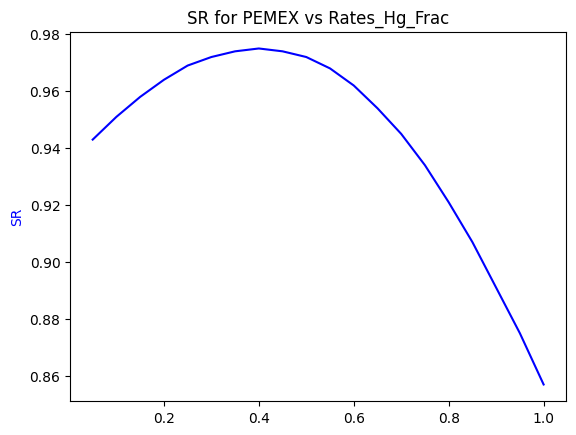

In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

l = list(all_dict.keys())
sr_list = [item[0] for item in all_dict.values()]

ax1.plot(l, sr_list, label='SR', color='blue')
ax1.set_ylabel('SR', color='blue')

# ax2 = ax1.twinx()
# # ax2.plot(l, pnl_list, label='Cum P/L', color='green')
# # ax2.set_ylabel('Cum P/L', color='green')

# ax2.plot(l, hit_list, label='Hit Rate', color='green')
# ax2.set_ylabel('Hit Rate', color='green')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines + lines2, labels + labels2, loc='best')
plt.title('SR for PEMEX vs Rates_Hg_Frac')

plt.show()

In [8]:
display(df_Both.dropna(how="all",axis=1).dropna(how='all'))
display(df_Long.dropna(how="all",axis=1).dropna(how='all'))
display(df_Short.dropna(how="all",axis=1).dropna(how='all'))

# df_Both.to_excel("PEMEX_Both_with_txn_21c.xlsx")
# df_Long.to_excel("PEMEX_Long_with_txn_21c.xlsx")
# df_Short.to_excel("PEMEX_Short_with_txn_21c.xlsx")

Exit,0.0
Entry,
$pnl_2,1536401.0
$pnl/trade_2,118185.0
SR_2,0.857
Hit_Ratio_2,84.615
trades_2,13
days/trade_2,32.0
max_DD_2,41831.0


Exit
Entry


Exit
Entry


In [9]:
dft = df_Both.copy()
flds = list(sorted(set([item.rsplit('_',1)[0] for item in dft.index])))

for fld in flds:
    x = dft[dft.index.isin([item for item in dft.index if item.rsplit('_',1)[0] == fld])].\
        dropna(how='all',axis=1).dropna(how='all').replace(np.nan,'-').copy()
    x.index = [item.rsplit('_',1)[1] for item in x.index]
    x.index.name = "(" + fld + ")" + ' Entry'
    display(x)

Exit,0.0
($pnl) Entry,
2,1536401.0


Exit,0.0
($pnl/trade) Entry,
2,118185.0


Exit,0.0
(Hit_Ratio) Entry,
2,84.615


Exit,0.0
(SR) Entry,
2,0.857


Exit,0.0
(days/trade) Entry,
2,32.0


Exit,0.0
(max_DD) Entry,
2,41831.0


Exit,0.0
(trades) Entry,
2,13


In [10]:
# # x.resample('D').last().fillna(0.0)
# len(test_df[((test_df['Sum'].diff()!=0) & ~pd.isna(test_df['Sum'].diff()))])

In [11]:
x1 = cds.copy()
x1['Cpn Rtn'] = [pd.to_datetime(np.nan)] + list(x1.index)[:-1]
x1['Cpn Rtn'] = (x1.index - x1['Cpn Rtn']).dt.days/360*x1['CDS Cpn']*x1['CDS Notional']*0.01
x1['CDS PX'] = (x1['CDS 5Y PX'] - x1['CDS 5Y PX'].shift())*0.01*x1['CDS Notional']
x1['CDS Rtn'] = x1['Cpn Rtn'] + x1['CDS PX']

x2 = bond.copy()
x2['Cpn Rtn'] = [pd.to_datetime(np.nan)] + list(x2.index)[:-1]
x2['Cpn Rtn'] = ((x2.index - x2['Cpn Rtn']).dt.days/360)*x2['Bond Notional']*.01*\
    (x2['Bond Cpn']-0.5*(x2['Long Fin. Cost'] + x2['Short Fin. Benefit'])*x2['Bond Price']/100)
x2['Bond PX'] = (x2['Bond Price'] - x2['Bond Price'].shift())*.01*x2['Bond Notional']
x2['Bond Rtn'] = x2['Cpn Rtn'] + x2['Bond PX']
x2 = x2.drop(['volume','Cpn Rtn','Bond PX'],axis=1)
x2

,Bond Price,Bond Cpn,Bond Notional,signal,Long Fin. Cost,Short Fin. Benefit,Bond Rtn
2015-10-09,100.550,6.625,4.698812e+06,-1.684793,0.38,-0.12,NaN
2015-10-13,99.500,6.625,4.708536e+06,-2.080116,0.38,-0.12,-46041.292620
2015-10-14,99.475,6.625,4.718580e+06,-2.320393,0.38,-0.12,-328.245079
2015-10-15,100.500,6.625,4.696861e+06,-1.879540,0.38,-0.12,48990.135204
2015-10-16,101.410,6.625,4.678032e+06,-1.586779,0.38,-0.12,43413.846260
...,...,...,...,...,...,...,...
2025-08-22,90.510,6.625,6.327355e+06,2.366122,4.58,4.08,77036.585258
2025-08-25,90.390,6.625,6.332145e+06,2.347252,4.58,4.08,-6167.976880
2025-08-26,89.795,6.625,6.339735e+06,1.438974,4.58,4.08,-37239.446226
2025-08-27,89.950,6.625,6.341413e+06,1.461441,4.58,4.08,10310.110210


In [12]:
x3 = rates.copy()
x3.index = pd.to_datetime(x3.index)
x4 = x3[['Rates_Hg','Long Fin. Cost','Short Fin. Benefit','Rates Notional']].copy()
x4['Rtn'] = np.nan
for item in x4.index:
    # rt = pd.concat([globals()[f'rates_{x4.loc[item,'Rates_Hg']}'],x3[[f'{x4.loc[item,'Rates_Hg']}_PX']]],axis=1).copy()
    rt = globals()[f'rates_{x4.loc[item,'Rates_Hg']}'].copy()
    rt['Cpn Rtn'] = [pd.to_datetime(np.nan)] + list(rt.index)[:-1]
    rt['Cpn Rtn'] = ((rt.index - rt['Cpn Rtn']).dt.days/360)*rt['Rates Notional']*.01*\
        (rt['Rates_Cpn']-0.5*(rt['Long Fin. Cost'] + rt['Short Fin. Benefit'])*rt['close']/100)
    rt['Bond PX'] = (rt['close'] - rt['close'].shift())*.01*rt['Rates Notional']
    rt['Bond Rtn'] = rt['Cpn Rtn'] + rt['Bond PX']
    rt = rt.drop(['volume','Cpn Rtn','Bond PX'],axis=1)
    x4.loc[item, 'Rtn'] = rt.loc[item,'Bond Rtn']#.iloc[:)
x4

,Rates_Hg,Long Fin. Cost,Short Fin. Benefit,Rates Notional,Rtn
2015-10-09,912828K7,0.38,-0.12,5.677081e+06,NaN
2015-10-13,912828K7,0.38,-0.12,5.676018e+06,23351.622337
2015-10-14,912828K7,0.38,-0.12,5.663355e+06,36574.999646
2015-10-15,912828K7,0.38,-0.12,5.651218e+06,-22664.488633
2015-10-16,912828K7,0.38,-0.12,5.631231e+06,-7626.345990
...,...,...,...,...,...
2025-08-22,91282CNR,4.58,4.08,7.162845e+06,38545.342790
2025-08-25,91282CNR,4.58,4.08,7.187765e+06,-11989.483029
2025-08-26,91282CNR,4.58,4.08,7.196274e+06,12301.344693
2025-08-27,91282CNR,4.58,4.08,7.191101e+06,17908.387230


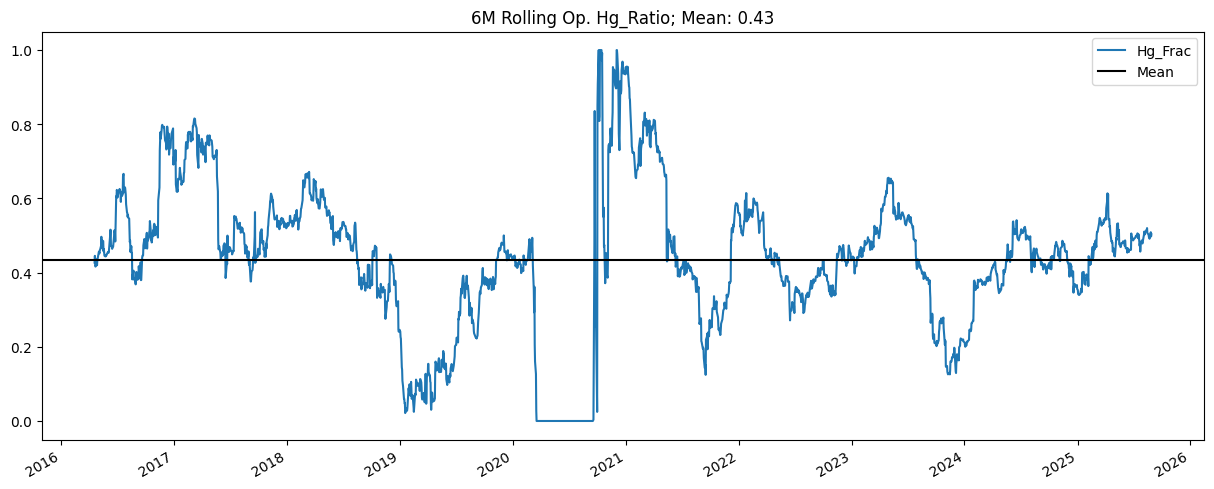

In [13]:
# x5 = pd.concat([x1[['CDS Rtn']], x2[['Bond Rtn']], x4[['Rtn']]], axis=1).dropna().copy()
# x5['Hg_Frac'] = np.nan

# period = 126

# for i in range(period-1, len(x5),1):
#     op = -1*x5['CDS Rtn'].iloc[i-period+1: i] + x5['Bond Rtn'].iloc[i-period+1: i] - hg_frac*x5['Rtn'].iloc[i-period+1: i]
#     minimize std of op by varying hg_frac as it varies from 0 to 1
#     and store that hg_frac value as x5.loc[x5.index[i],'Hg_Frac'] = hg_frac
# x5

import numpy as np
import pandas as pd

x5 = pd.concat([x1[['CDS Rtn']], x2[['Bond Rtn']], x4[['Rtn']]], axis=1).dropna().copy()

period = 126
y = -x5['CDS Rtn'] + x5['Bond Rtn']
z = x5['Rtn']

cov = y.rolling(window=period).cov(z)
varz = z.rolling(window=period).var()
h = (cov / varz).replace([np.inf, -np.inf], np.nan)

x5['Hg_Frac'] = h.clip(0, 1).shift(1)

x5['Hg_Frac'].plot(figsize=(15,6))
plt.title(f'{period/21:.0f}M Rolling Op. Hg_Ratio; Mean: {x5['Hg_Frac'].mean():.2f}')
plt.axhline(x5['Hg_Frac'].mean(), color='black',label='Mean')
plt.legend()
plt.show()

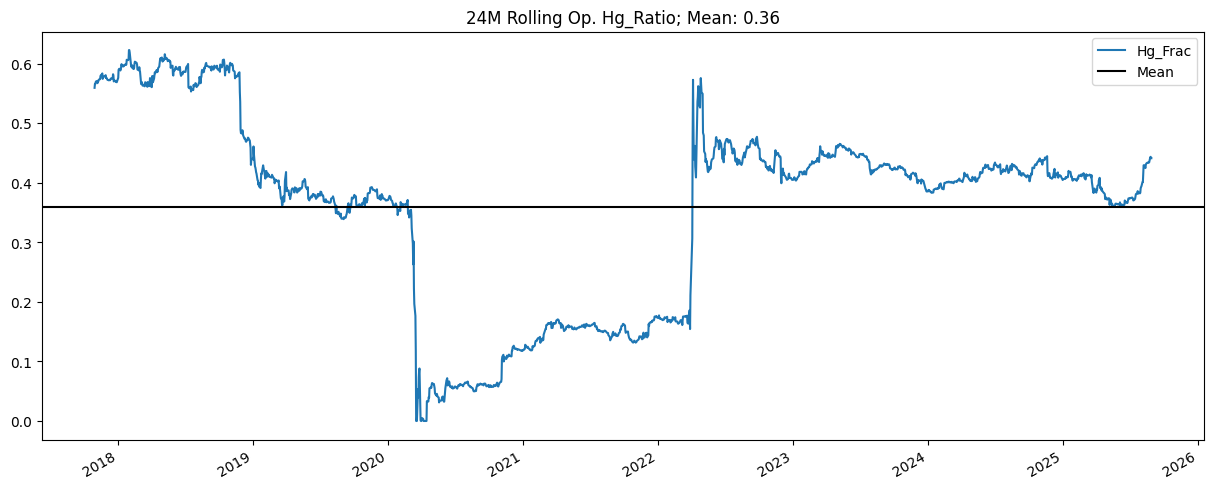

In [14]:
# x5 = pd.concat([x1[['CDS Rtn']], x2[['Bond Rtn']], x4[['Rtn']]], axis=1).dropna().copy()
# x5['Hg_Frac'] = np.nan

# period = 126

# for i in range(period-1, len(x5),1):
#     op = -1*x5['CDS Rtn'].iloc[i-period+1: i] + x5['Bond Rtn'].iloc[i-period+1: i] - hg_frac*x5['Rtn'].iloc[i-period+1: i]
#     minimize std of op by varying hg_frac as it varies from 0 to 1
#     and store that hg_frac value as x5.loc[x5.index[i],'Hg_Frac'] = hg_frac
# x5

import numpy as np
import pandas as pd

x5 = pd.concat([x1[['CDS Rtn']], x2[['Bond Rtn']], x4[['Rtn']]], axis=1).dropna().copy()

period = 126*2*2
y = -x5['CDS Rtn'] + x5['Bond Rtn']
z = x5['Rtn']

cov = y.rolling(window=period).cov(z)
varz = z.rolling(window=period).var()
h = (cov / varz).replace([np.inf, -np.inf], np.nan)

x5['Hg_Frac'] = h.clip(0, 1).shift(1)

x5['Hg_Frac'].plot(figsize=(15,6))
plt.title(f'{period/21:.0f}M Rolling Op. Hg_Ratio; Mean: {x5['Hg_Frac'].mean():.2f}')
plt.axhline(x5['Hg_Frac'].mean(), color='black',label='Mean')
plt.legend()
plt.show()

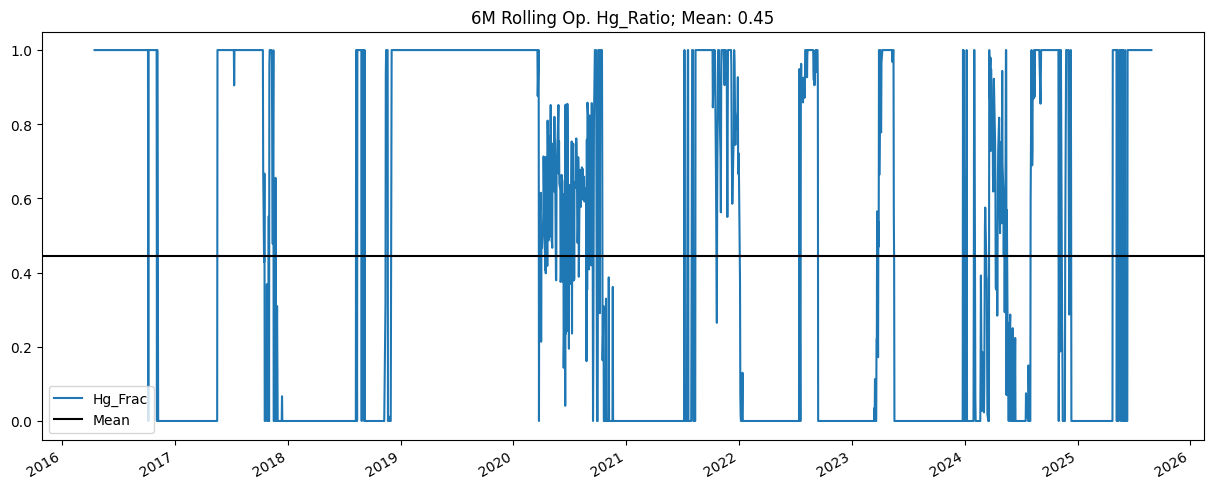

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

x5 = pd.concat([x1[['CDS Rtn']], x2[['Bond Rtn']], x4[['Rtn']]], axis=1).dropna().copy()
x5['Hg_Frac'] = np.nan

period = 126*1

for i in range(period-1, len(x5)):
    # i = period-1
    cds = x5['CDS Rtn'].iloc[i-period+1:i+1]
    bond = x5['Bond Rtn'].iloc[i-period+1:i+1]
    rtn = x5['Rtn'].iloc[i-period+1:i+1]
    def neg_sr(h):
        # op = -cds + bond - h*rtn
        op = cds - bond + h*rtn
        op = op.cumsum()    
        # display(op)
        op += 10**6    
        op = op.pct_change().dropna()
        if len(op) == 0:
            return np.inf
        s = op.std()
        if s == 0 or np.isnan(s):
            return np.inf
        return -(op.mean()/s)
    
    res = minimize_scalar(neg_sr, bounds=(0.0, 1.0), method='bounded', options={'xatol': 1e-6, 'maxiter': 10**7})
    x5.loc[x5.index[i], 'Hg_Frac'] = np.clip(res.x, 0.0, 1.0) if res.success else np.nan
    x5.dropna()

x5['Hg_Frac'].plot(figsize=(15,6))
plt.title(f'{period/21:.0f}M Rolling Op. Hg_Ratio; Mean: {x5['Hg_Frac'].mean():.2f}')
plt.axhline(x5['Hg_Frac'].mean(), color='black',label='Mean')
plt.legend()
plt.show()

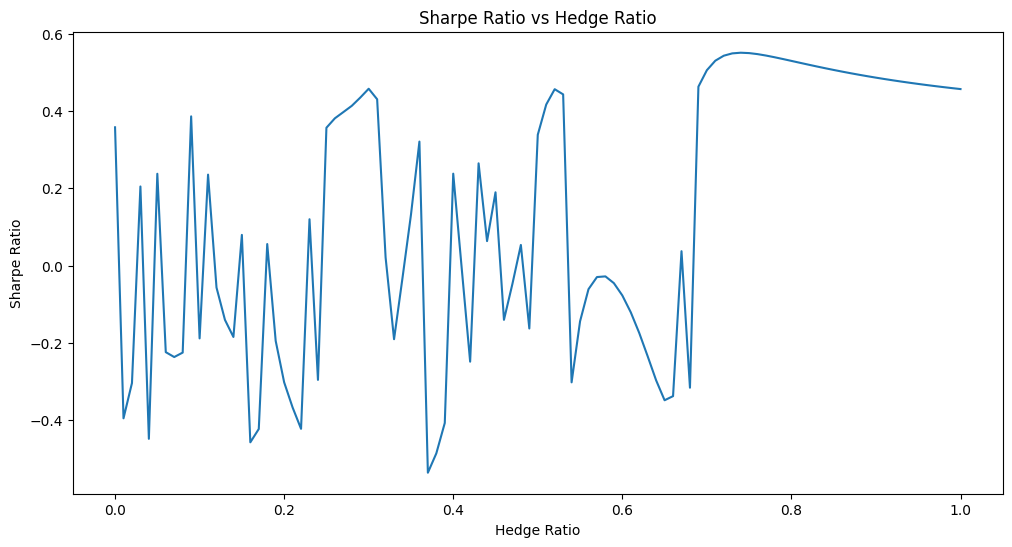

In [16]:

import numpy as np
import matplotlib.pyplot as plt

cds = x5['CDS Rtn']
bond = x5['Bond Rtn']
rtn = x5['Rtn']

hg_ratio = np.arange(0, 1.01, 0.01)  # hedge ratios from 0 to 1
sr = []

for h in hg_ratio:
    op = cds - bond + h * rtn
    op = op.cumsum()
    op += 10**6
    op = op.pct_change().dropna()
    sharpe = op.mean() * np.sqrt(252) / op.std()
    sr.append(sharpe)

plt.figure(figsize=(12,6))
plt.plot(hg_ratio, sr)
plt.title('Sharpe Ratio vs Hedge Ratio')
plt.xlabel('Hedge Ratio')
plt.ylabel('Sharpe Ratio')
# plt.grid(True)
plt.show()


In [17]:
all_dict

{0.05: [0.943, 1813945.0],
 0.1: [0.951, 1799338.0],
 0.15: [0.958, 1784730.0],
 0.2: [0.964, 1770122.0],
 0.25: [0.969, 1755515.0],
 0.3: [0.972, 1740907.0],
 0.35: [0.974, 1726300.0],
 0.4: [0.975, 1711692.0],
 0.45: [0.974, 1697084.0],
 0.5: [0.972, 1682477.0],
 0.55: [0.968, 1667869.0],
 0.6: [0.962, 1653261.0],
 0.65: [0.954, 1638654.0],
 0.7: [0.945, 1624046.0],
 0.75: [0.934, 1609439.0],
 0.8: [0.921, 1594831.0],
 0.85: [0.907, 1580223.0],
 0.9: [0.891, 1565616.0],
 0.95: [0.875, 1551008.0],
 1.0: [0.857, 1536401.0]}